In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt


Welcome to JupyROOT 6.20/04


In [2]:
sg_file = uproot.open("/data/event/final/sg_10ppwax/Events/run_01/tag_1_delphes_events.root") 
bg_file = uproot.open("/data/event/final/bg_ppaalvll/Events/run_01/tag_1_delphes_events.root")
bg_jet_file = uproot.open("/data/event/final/bgjet_pplvllj/Events/run_01/tag_1_delphes_events.root")

m_ax = 10

sg_Xsection = 14060
bg_Xsection = 94.37
j_Xsection = 5887000

# sg_X  1(15990) 5(15250) 10(14060) 15(12870) 20(11850)  25(10890)
# bg_x  94.37
# j_x   5887000

In [3]:
def file_np(file):
    event = [ file["Delphes;1"]["Electron"].array(),
              file["Delphes;1"]["Electron.PT"].array(),
              file["Delphes;1"]["Electron.Eta"].array(),
              file["Delphes;1"]["Electron.Phi"].array(),
              file["Delphes;1"]["Muon"].array(),                #4
              file["Delphes;1"]["Muon.PT"].array(),
              file["Delphes;1"]["Muon.Eta"].array(),
              file["Delphes;1"]["Muon.Phi"].array(),
              file["Delphes;1"]["Photon"].array(),              #8
              file["Delphes;1"]["Photon.PT"].array(),
              file["Delphes;1"]["Photon.Eta"].array(),
              file["Delphes;1"]["Photon.Phi"].array(),
              file["Delphes;1"]["MissingET"].array(),           #12
              file["Delphes;1"]["MissingET.fUniqueID"].array(),   
              file["Delphes;1"]["MissingET.fBits"].array(),
              file["Delphes;1"]["MissingET.MET"].array(),
              file["Delphes;1"]["MissingET.Eta"].array(),
              file["Delphes;1"]["MissingET.Phi"].array(),
              file["Delphes;1"]["Jet"].array(),                 #18
              file["Delphes;1"]["Jet.EhadOverEem"].array(),     
              file["Delphes;1"]["Jet.Mass"].array(),
              file["Delphes;1"]["Event.Number"].array(),
              file["Delphes;1"]["Jet.Tau[5]"].array(),
              file["Delphes;1"]["Jet.PT"].array(),              #23
              file["Delphes;1"]["Jet.Eta"].array(),
              file["Delphes;1"]["Jet.Phi"].array(),
              file["Delphes;1"]["Jet.Constituents"].array(),    #26
              file["Delphes;1"]["Jet.Particles"].array(),
              file["Delphes;1"]["Particle.PID"].array(),
              file["Delphes;1"]["Particle.PT"].array(),
              file["Delphes;1"]["Particle.Eta"].array(),
              file["Delphes;1"]["Particle.Phi"].array(),
              file["Delphes;1"]["Jet.FracPt[5]"].array(),       #32
              file["Delphes;1"]["Jet.TrimmedP4[5]"].array(),
              file["Delphes;1"]["Jet.PrunedP4[5]"].array(),
              file["Delphes;1"]["Jet.SoftDroppedP4[5]"].array()
              ]
    
    event = np.expand_dims(event, axis=-1)    ### reshape data
    event = event.transpose((1,0,2))
    event = np.squeeze(event,axis=(2,))
    return event 



In [4]:
bg_events = file_np(bg_file)
sg_events = file_np(sg_file)
j_events = file_np(bg_jet_file)

In [5]:
me = 0.000511
mu = 0.10566

max_shift = m_ax*0.1
if m_ax == 1:
    max_u = 2
    max_d = 0.5
else:
    max_u = m_ax + 2*max_shift
    max_d = m_ax - max_shift
################################################
def prlen(events):
    print(len(events))

################################################  simple sel (any=? l=1 j>1)
def num_sl(event,lab,num):
    where1 = np.where(event[:,lab]==num)
    return event[where1]

def l_sl(event):
    where1 = np.where(event[:,0]+event[:,4]==1)
    return event[where1]

def j_sl(event):
    where1 = np.where(event[:,18]>0)
    return(event[where1])  

def Ehover(event,sl_jet):
    where=[]
    for i in range(len(event)):
        if np.min(event[i][19])<0.2:
            where.append(i)
            sl_jet.append(np.min(event[i][19]))
    return event[where]   
        
################################################  maa caculate
def m_aa(events, m, pt1):
    where1=[]   
    for i in range(len(events)):
        p = [0,0,0,0] 
        for j in range(events[i][8]):
            pt = events[i][9][j]   
            eta = events[i][10][j]  
            phi = events[i][11][j]    
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
            p[3] = p[3] + pt*np.sinh(eta)   ### pz
            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )     
        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(maa)
        pTaa = np.sqrt(p[1]**2 + p[2]**2)
        pt1.append(pTaa)
        if 90<maa<110:
            where1.append(i)
    return events[where1]
################################################   pt sl    
def pt_sl(events):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]    
        for j in range(events[i][8]):
            pt = events[i][9][j]    
            eta = events[i][10][j]    
            phi = events[i][11][j]   
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
        pTaa = np.sqrt(p[1]**2 + p[2]**2)    
        if pTaa>50:
              where1.append(i)
    return events[where1]
################################################ mlv caculate
def mvl_sl(events,m):
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(mlv)
################################################## must 1l events
def MTvl_sl(events,m,pt):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2)
            mlv  = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 )
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        
        m.append(mlv)
        pt.append(ptlv)
        if mlv > 58:
            where1.append(i)
    return(events[where1])
##################################################   
def PTvl_sl(events):
    where1=[]
    m=[]
    pt=[]
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2)
            mlv  = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 )
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        m.append(mlv)
        pt.append(ptlv)
        if ptlv > 50:
            where1.append(i)
    return(events[where1])
#######################################################################################

def j_mass(events,j_mass):
    where = []
    for i in range(len(events)):
        where1 = np.where(events[i][19]==np.min(events[i][19]))
        for j in range(len(where1[0])):
            jet_m = events[i][20][where1[0][j]]
            j_mass.append(jet_m)
            where.append(i)  
    c = np.unique(where)
    return events[c]


##################################################
def j_mass_sl(events,j_mass):
    where = []
    for i in range(len(events)):
        where1 = np.where(events[i][19]==np.min(events[i][19]))
        for j in range(len(where1[0])):
            jet_m = events[i][20][where1[0][j]]
            if max_d<jet_m<max_u:
                j_mass.append(jet_m)
                where.append(i)  
    if not where:
        c = []
    else:
        c = np.unique(where)
    return events[c]
#######################################################################################
def draw_tau2overtau1(events,tau2overtau1):
    for i in range(len(events)):
        where1 = np.where(events[i][19]==np.min(events[i][19]))
        for j in range(len(where1[0])):
            tau1 = events[i][22][where1[0][j]][0]
            tau2 = events[i][22][where1[0][j]][1]
            if tau1 != 0 :
                tau2overtau1.append(tau2/tau1)
                
def draw_tau2_tau1(events,tau1_list,tau2_list):
    for i in range(len(events)):
        where1 = np.where(events[i][19]==np.min(events[i][19]))
        for j in range(len(where1[0])):
            tau1 = events[i][22][where1[0][j]][0]
            tau2 = events[i][22][where1[0][j]][1]
        tau1_list.append(tau1)
        tau2_list.append(tau2)    
                       
def tau2overtau1_sl(events):
    where = []
    for i in range(len(events)):
        where1 = np.where(events[i][19]==np.min(events[i][19]))
        for j in range(len(where1[0])):
            tau1 = events[i][22][where1[0][j]][0]
            tau2 = events[i][22][where1[0][j]][1]
            if tau1 != 0 :
                if tau2/tau1<0.05:
                    where.append(i)
    return events[where]
                               
            
##################################################        
def phi_v(events,phi_list):
    for i in range(len(events)):
        if events[i][0]==1:
            for j in range(len(events[i][3])):
                phi = (events[i][2][j])
                phi_list.append(phi)
        elif events[i][4]==1:
            for j in range(len(events[i][7])):
                phi = events[i][6][j]
                phi_list.append(phi)  
                
def miss_v(events,phi_list):
    for i in range(len(events)):
        for j in range(len(events[i][16])):
            phi = (events[i][17][j])
            phi_list.append(phi)
##################################################  soon drow [i] hist
def soon_draw(events,num,min1,max1,bin_num):
    list1=[]
    for i in range(len(events)):
        if type(events[i][num])==int:
            list1.append(events[i][num])
        else:
            for j in range(len(events[i][num])):
                list1.append(events[i][num][j])
    bins = np.arange(min1,max1,bin_num)
    plt.hist(list1,bins=bins,histtype='step')
    plt.title(feture[num])
    plt.show
def soon_drawvs(sg_events,bg_events,num,min1,max1,bin_num):
    list1=[]
    list2=[]
    for i in range(len(sg_events)):
        if type(sg_events[i][num])==int:
            list1.append(sg_events[i][num])
        else:
            for j in range(len(sg_events[i][num])):
                list1.append(sg_events[i][num][j])
                
    for i in range(len(bg_events)):
        if type(bg_events[i][num])==int:
            list2.append(bg_events[i][num])
        else:
            for j in range(len(bg_events[i][num])):
                list2.append(bg_events[i][num][j])
                
    bins = np.arange(min1,max1,bin_num)
    plt.hist([list1,list2] , bins=bins, histtype='step', label=['sg','bg'],color=['red','darkblue'])
    plt.title(feture[num])
    plt.legend()
    plt.show()    
    
########################################################################################
def significance(s,b):   ### t = (sigma b)^2
    t = (b*0.05)**2
    g = 2*((s+b)*np.log((s+b)*(b+t)/(b**2+(s+b)*t))-((b**2)/t)*np.log(1+(t*s/(b*(b+t)))))
    return np.sqrt(g)
###################################################
def significance2(s,b):
    return np.sqrt(2*((s+b)*np.log(1+s/b)-s))
###########################################
def z_2(f, left, right, epsilon=1e-12):
    if left >= right:
        return None

    while abs(right - left) > epsilon:
        mid = (left + right) / 2
        f_mid = f(mid,b)-2
        if f_mid == 0:
            return mid
        elif f_mid < 0:
            left = mid
        elif f_mid > 0:
            right = mid

    return (left + right) / 2


In [6]:
jEho_sg_1j_Eho=[]
jEho_bg_1j_Eho=[]
jEho_j_1j_Eho=[]


############################# MT PT
MTv_sgsl_1j_Eho_1l = []
MTv_bgsl_1j_Eho_1l = []
MTv_jsl_1j_Eho_1l = []

PTv_sgsl_1j_Eho_1l = []
PTv_bgsl_1j_Eho_1l = []
PTv_jsl_1j_Eho_1l = []

###################################################sl: 1j -> Eho<0.2 -> 1l
sgsl_1j = j_sl(sg_events)
sgsl_1j_Eho = Ehover(sgsl_1j,jEho_sg_1j_Eho)
sgsl_1j_Eho_1l = l_sl(sgsl_1j_Eho)

bgsl_1j = j_sl(bg_events)
bgsl_1j_Eho = Ehover(bgsl_1j,jEho_bg_1j_Eho)
bgsl_1j_Eho_1l = l_sl(bgsl_1j_Eho)

jsl_1j = j_sl(j_events)
jsl_1j_Eho = Ehover(jsl_1j,jEho_j_1j_Eho)
jsl_1j_Eho_1l = l_sl(jsl_1j_Eho)
####################################################sl: 8<jmass<15  ***************************************************************


sgsl_1j_Eho_1l_MT = MTvl_sl(sgsl_1j_Eho_1l,MTv_sgsl_1j_Eho_1l,PTv_sgsl_1j_Eho_1l)
bgsl_1j_Eho_1l_MT = MTvl_sl(bgsl_1j_Eho_1l,MTv_bgsl_1j_Eho_1l,PTv_bgsl_1j_Eho_1l)
jsl_1j_Eho_1l_MT = MTvl_sl(jsl_1j_Eho_1l,MTv_jsl_1j_Eho_1l,PTv_jsl_1j_Eho_1l)
####################################################

sgsl_1j_Eho_1l_MT_t21 = tau2overtau1_sl(sgsl_1j_Eho_1l_MT)
bgsl_1j_Eho_1l_MT_t21 = tau2overtau1_sl(bgsl_1j_Eho_1l_MT)
jsl_1j_Eho_1l_MT_t21 = tau2overtau1_sl(jsl_1j_Eho_1l_MT)

####################################################

jmass_sgsl_1j_Eho_1l_MT_t21=[]
jmass_sgsl_1j_Eho_1l_MT_t21=[]
jmass_jsl_1j_Eho_1l_MT_t21=[]

sgsl_1j_Eho_1l_MT_t21_jm = j_mass_sl(sgsl_1j_Eho_1l_MT_t21,jmass_sgsl_1j_Eho_1l_MT_t21)
bgsl_1j_Eho_1l_MT_t21_jm = j_mass_sl(bgsl_1j_Eho_1l_MT_t21,jmass_sgsl_1j_Eho_1l_MT_t21)
jsl_1j_Eho_1l_MT_t21_jm = j_mass_sl(jsl_1j_Eho_1l_MT_t21,jmass_jsl_1j_Eho_1l_MT_t21)

####################################################

# sg_Xsection = 14060
# bg_Xsection = 94.37
# j_Xsection = 5887000

    
# b1 = bg_Xsection*(bgsl_event/bgNsl_event)*Lum[k]
# b2 = j_Xsection*(jsl_event/jNsl_event)*Lum[k]
# b = b1 + b2

def s300(sgsl_event):
    s = sg_Xsection*(len(sgsl_event)/len(sg_events))*300
    return s

def b300(bgsl_event):
    b1 = bg_Xsection*(len(bgsl_event)/len(bg_events))*300
    return b1
    
def j300(jsl_event):
    b2 = j_Xsection*(len(jsl_event)/len(j_events))*300
    return b2
    
####################################################
print('\033[0;34msg sg_event number :\033[0m',len(sg_events))
print('\033[0;34msg after 1j sl :\033[0m',len(sgsl_1j))
print('\033[0;34msg after 1j,EhadOverEem<0.2 sl :\033[0m',len(sgsl_1j_Eho))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l sl :\033[0m',len(sgsl_1j_Eho_1l))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,MTvl>58 sl :\033[0m',len(sgsl_1j_Eho_1l_MT))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 sl :\033[0m',len(sgsl_1j_Eho_1l_MT_t21))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',len(sgsl_1j_Eho_1l_MT_t21_jm))
print('')
print('\033[0;33mbg sg_event number :\033[0m',len(bg_events))
print('\033[0;33mbg after 1j sl :\033[0m',len(bgsl_1j))
print('\033[0;33mbg after 1j,EhadOverEem<0.2 sl :\033[0m',len(bgsl_1j_Eho))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l sl :\033[0m',len(bgsl_1j_Eho_1l))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,MTvl>58 sl :\033[0m',len(bgsl_1j_Eho_1l_MT))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 sl :\033[0m',len(bgsl_1j_Eho_1l_MT_t21))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',len(bgsl_1j_Eho_1l_MT_t21_jm))
print('')
print('\033[0;32mjet_bg jet_bg_event number :\033[0m',len(j_events))
print('\033[0;32mjet_bg after 1j sl :\033[0m',len(jsl_1j))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2 sl :\033[0m',len(jsl_1j_Eho))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l sl :\033[0m',len(jsl_1j_Eho_1l))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,MTvl>58 sl :\033[0m',len(jsl_1j_Eho_1l_MT))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 sl :\033[0m',len(jsl_1j_Eho_1l_MT_t21))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',len(jsl_1j_Eho_1l_MT_t21_jm))
print('')
####################################################
print('\033[0;34msg sg_event number :\033[0m',s300(sg_events))
print('\033[0;34msg after 1j sl :\033[0m',s300(sgsl_1j))
print('\033[0;34msg after 1j,EhadOverEem<0.2 sl :\033[0m',s300(sgsl_1j_Eho))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l sl :\033[0m',s300(sgsl_1j_Eho_1l))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,MTvl>58 sl :\033[0m',s300(sgsl_1j_Eho_1l_MT))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 sl :\033[0m',s300(sgsl_1j_Eho_1l_MT_t21))
print('\033[0;34msg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',s300(sgsl_1j_Eho_1l_MT_t21_jm))
print('')
print('\033[0;33mbg sg_event number :\033[0m',b300(bg_events))
print('\033[0;33mbg after 1j sl :\033[0m',b300(bgsl_1j))
print('\033[0;33mbg after 1j,EhadOverEem<0.2 sl :\033[0m',b300(bgsl_1j_Eho))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l sl :\033[0m',b300(bgsl_1j_Eho_1l))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,MTvl>58 sl :\033[0m',b300(bgsl_1j_Eho_1l_MT))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 sl :\033[0m',b300(bgsl_1j_Eho_1l_MT_t21))
print('\033[0;33mbg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',b300(bgsl_1j_Eho_1l_MT_t21_jm))
print('')
print('\033[0;32mjet_bg jet_bg_event number :\033[0m',j300(j_events))
print('\033[0;32mjet_bg after 1j sl :\033[0m',j300(jsl_1j))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2 sl :\033[0m',j300(jsl_1j_Eho))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l sl :\033[0m',j300(jsl_1j_Eho_1l))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,MTvl>58 sl :\033[0m',j300(jsl_1j_Eho_1l_MT))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 sl :\033[0m',j300(jsl_1j_Eho_1l_MT_t21))
print('\033[0;32mjet_bg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05',max_d,'<jmass<',max_u,' sl :\033[0m',j300(jsl_1j_Eho_1l_MT_t21_jm))


sg sg_event number : 10000
sg after 1j sl : 7799
sg after 1j,EhadOverEem<0.2 sl : 6596
sg after 1j,EhadOverEem<0.2,1l sl : 3349
sg after 1j,EhadOverEem<0.2,1l,MTvl>58 sl : 2107
sg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 sl : 1411
sg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 9.0 <jmass< 12.0  sl : 1094

bg sg_event number : 100000
bg after 1j sl : 47385
bg after 1j,EhadOverEem<0.2 sl : 24105
bg after 1j,EhadOverEem<0.2,1l sl : 7896
bg after 1j,EhadOverEem<0.2,1l,MTvl>58 sl : 2702
bg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 sl : 708
bg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 9.0 <jmass< 12.0  sl : 7

jet_bg jet_bg_event number : 100000
jet_bg after 1j sl : 83279
jet_bg after 1j,EhadOverEem<0.2 sl : 14256
jet_bg after 1j,EhadOverEem<0.2,1l sl : 1537
jet_bg after 1j,EhadOverEem<0.2,1l,MTvl>58 sl : 951
jet_bg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 sl : 34
jet_bg after 1j,EhadOverEem<0.2,1l,MTvl>58,tau2/tau1<0.05 9.0 <jmass< 12.0  sl : 0



In [7]:
#        file["Delphes;1"]["Jet.Constituents"].array(),    #26
#               file["Delphes;1"]["Jet.Particles"].array(),
#               file["Delphes;1"]["Particle.PID"].array(),
#               file["Delphes;1"]["Particle.PT"].array(),
#               file["Delphes;1"]["Particle.Eta"].array(),
#               file["Delphes;1"]["Particle.Phi"].array()

event = 744
print(sgsl_1j_Eho_1l[event][18])  #jet number
print(sgsl_1j_Eho_1l[event][20])  #Mjet
print(sgsl_1j_Eho_1l[event][23])  #pt
print(sgsl_1j_Eho_1l[event][24])  #eta
print(sgsl_1j_Eho_1l[event][25])  #phi
print("")  
print(sgsl_1j_Eho_1l[event][22])  #tau
print("")  
print(sgsl_1j_Eho_1l[event][26])  #Jet Constituents
print(sgsl_1j_Eho_1l[event][27])  #Jet Particles
# print(sgsl_1j_Eho_1l[event][28])  #Particle PID
# print(sgsl_1j_Eho_1l[event][29])  #Particle PT
# print(sgsl_1j_Eho_1l[event][30])  #Particle Eta
# print(sgsl_1j_Eho_1l[event][31])  #Particle phi


 #Particle phi

    
    
print(len(sgsl_1j_Eho_1l[event][28]))
print(len(sgsl_1j_Eho_1l[event][29]))
print(len(sgsl_1j_Eho_1l[event][30]))
print(len(sgsl_1j_Eho_1l[event][31]))

2
[ 5.0736599e+00 -1.3486991e-06]
[32.920868 23.693289]
[-1.3805232  2.1038942]
[2.976798  2.0824802]

[[0.3662268  0.15780897 0.02983113 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]

[[1633, 1636, 1641, 1645], [1487]]
[[538, 541, 750, 540, 598], [468]]
1021
1021
1021
1021


jet num: 2
[-0.08005823  2.1621099 ]
[ 1.0870775 -2.8973494]


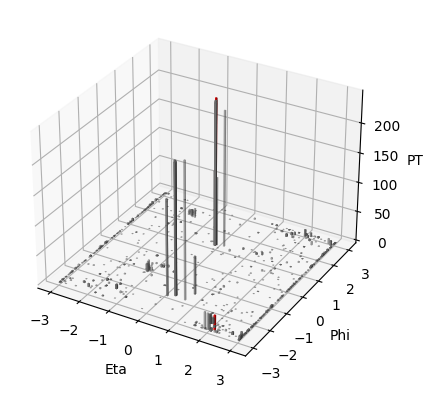

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

event = 20
print('jet num:',sgsl_1j_Eho_1l[event][18])
# 示例数据，替换为你的实际数据
PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT 
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta 
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi 

PT2 = sgsl_1j_Eho_1l[event][23]  # jet PT 
Eta2 = sgsl_1j_Eho_1l[event][24]  # jet Eta 
phi2 = sgsl_1j_Eho_1l[event][25]  # jet phi 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


dx = dy = 0.05

Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)


ax.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)
ax.bar3d(Eta2, phi2, np.zeros_like(PT2), dx, dy, PT2, color='red', alpha=1, shade=True)

print(Eta2)
print(phi2)

ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_zlabel('PT')

plt.show()



jet num: 2
Original Eta2: [ 0.8884339 -2.6048968]
Original phi2: [ 3.130978 -2.265746]


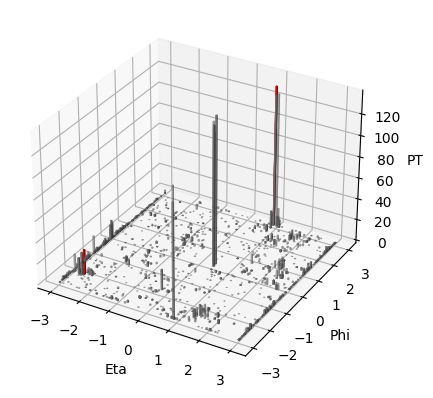

Clipped Eta2: [ 0.8884339 -2.6048968]
Clipped phi2: [ 3.       -2.265746]


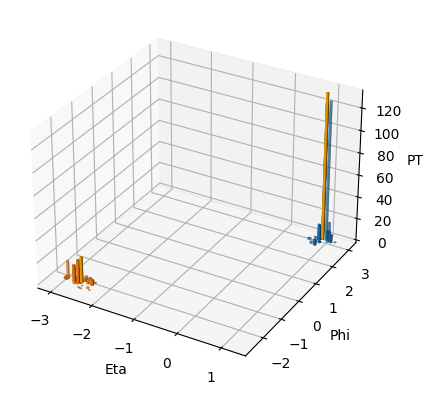

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

event = 14
print('jet num:', sgsl_1j_Eho_1l[event][18])

# 示例数据，替换为你的实际数据
PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT 
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta 
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi 

PT2 = sgsl_1j_Eho_1l[event][23]  # jet PT 
Eta2 = sgsl_1j_Eho_1l[event][24]  # jet Eta 
phi2 = sgsl_1j_Eho_1l[event][25]  # jet phi 

print('Original Eta2:', Eta2)
print('Original phi2:', phi2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

dx = dy = 0.05

Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)



ax.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)
ax.bar3d(Eta2, phi2, np.zeros_like(PT2), dx, dy, PT2, color='red', alpha=1, shade=True)

ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_zlabel('PT')

plt.show()

# 第二组图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 查找半径0.4内的粒子
selected_particles = []
for eta, phi in zip(Eta2, phi2):
    distances = np.sqrt((Eta1 - eta)**2 + (phi1 - phi)**2)
    mask = distances < 0.4
    selected_particles.append({
        'Eta': Eta1[mask],
        'Phi': phi1[mask],
        'PT': PT1[mask]
    })
    
print('Clipped Eta2:', Eta2)
print('Clipped phi2:', phi2)
for i, particles in enumerate(selected_particles):
    ax.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], alpha=0.5, shade=True)

# 确保使用与第一段代码中相同的 dx 和 dy
ax.bar3d(Eta2, phi2, np.zeros_like(PT2), dx, dy, PT2, color='orange', alpha=1, shade=True)

ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_zlabel('PT')

plt.show()


jet num: 1
tau: [[0.11420242 0.00198968 0.00072061 0.         0.        ]]


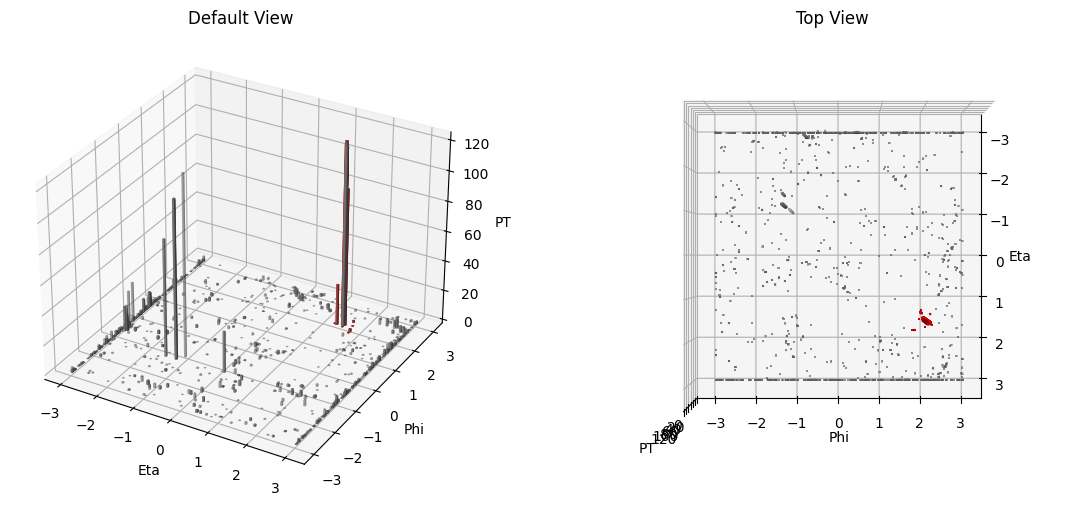

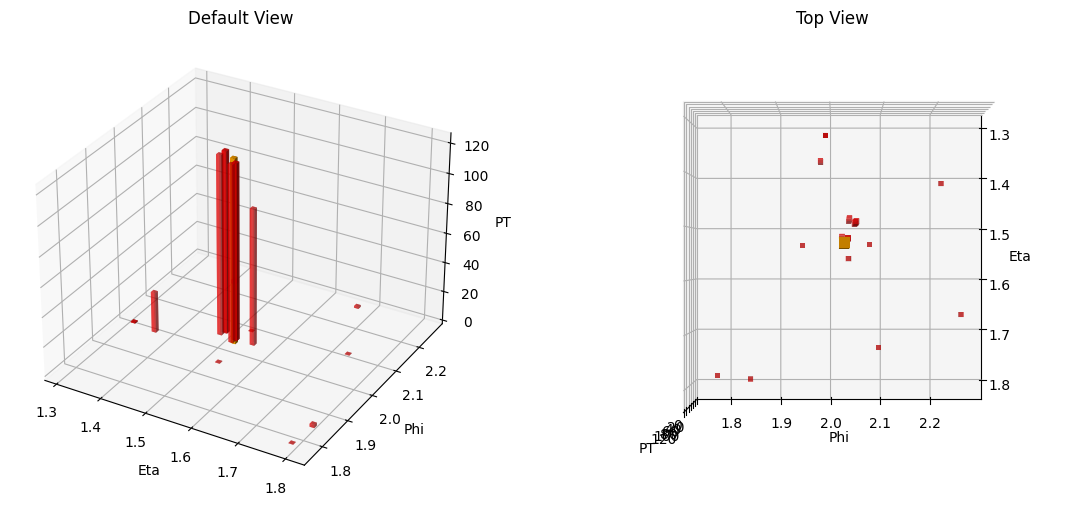

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

event = 180
#520
print('jet num:', sgsl_1j_Eho_1l[event][18])
print('tau:', sgsl_1j_Eho_1l[event][22])

PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT for the first dataset
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta for the first dataset
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi for the first dataset

PT2 = sgsl_1j_Eho_1l[event][23]  # Particle PT for the second dataset (jets)
Eta2 = sgsl_1j_Eho_1l[event][24]  # Particle Eta for the second dataset (jets)
phi2 = sgsl_1j_Eho_1l[event][25]  # Particle phi for the second dataset (jets)


dx = dy = 0.05


Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)

# 查找半径0.4内的粒子
selected_particles = []
for eta, phi in zip(Eta2, phi2):
    distances = np.sqrt((Eta1 - eta)**2 + (phi1 - phi)**2)
    mask = distances < 0.4
    selected_particles.append({
        'Eta': Eta1[mask],
        'Phi': phi1[mask],
        'PT': PT1[mask]
    })

#//////////////////////////////////////////////////////////////////////////////////////////////////////////////////
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

# 绘制所有粒子
ax1.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
colors = ['red', 'blue', 'green']
for i, particles in enumerate(selected_particles):
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：俯视图
ax2 = fig.add_subplot(122, projection='3d')

# 绘制所有粒子
ax2.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
for i, particles in enumerate(selected_particles):
    ax2.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_zlabel('PT')
ax2.set_title('Top View')

# 设置俯视图视角
ax2.view_init(elev=90, azim=0)

plt.show()

#//////////////////////////////////////////////////////////////////////////////////////////////////////////////////
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

dx2 = dy2 = 0.01

for i, particles in enumerate(selected_particles):
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx2, dy2, particles['PT'], color=colors[i], alpha=0.5, shade=True)
    
ax1.bar3d(Eta2, phi2, np.zeros_like(PT2), dx2, dy2, PT2, color='orange', alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：俯视图
ax2 = fig.add_subplot(122, projection='3d')

for i, particles in enumerate(selected_particles):
    ax2.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx2, dy2, particles['PT'], color=colors[i], alpha=0.5, shade=True)
    
ax2.bar3d(Eta2, phi2, np.zeros_like(PT2), 0.02, 0.02, PT2, color='orange', alpha=1, shade=True)

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_zlabel('PT')
ax2.set_title('Top View')

# 设置俯视图视角
ax2.view_init(elev=90, azim=0)

plt.show()


jet num: 3
tau: [[0.07365995 0.03474485 0.00422886 0.00218637 0.00096207]
 [0.21766736 0.09860615 0.06664688 0.03547334 0.02338329]
 [0.12209708 0.08806089 0.04814114 0.03027541 0.01438419]]


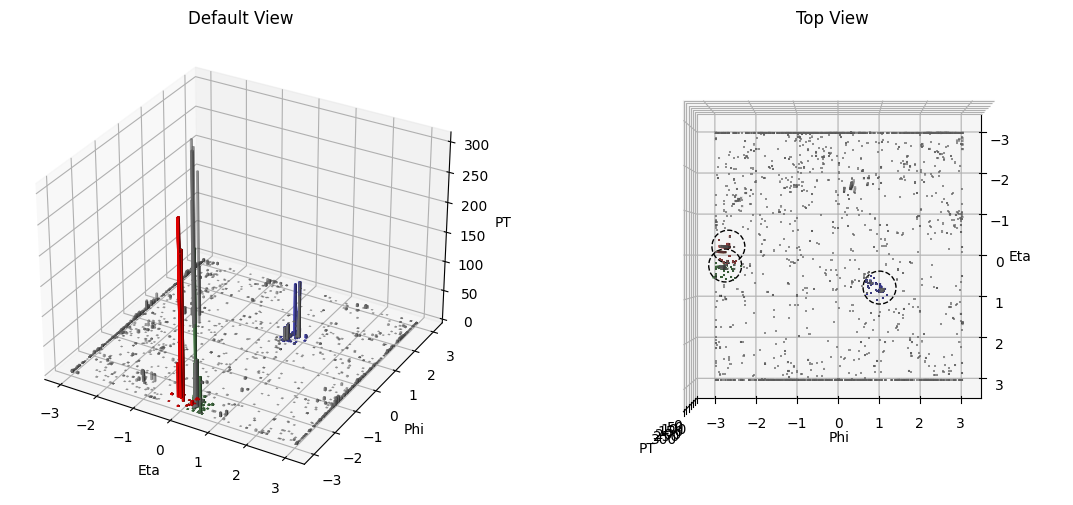

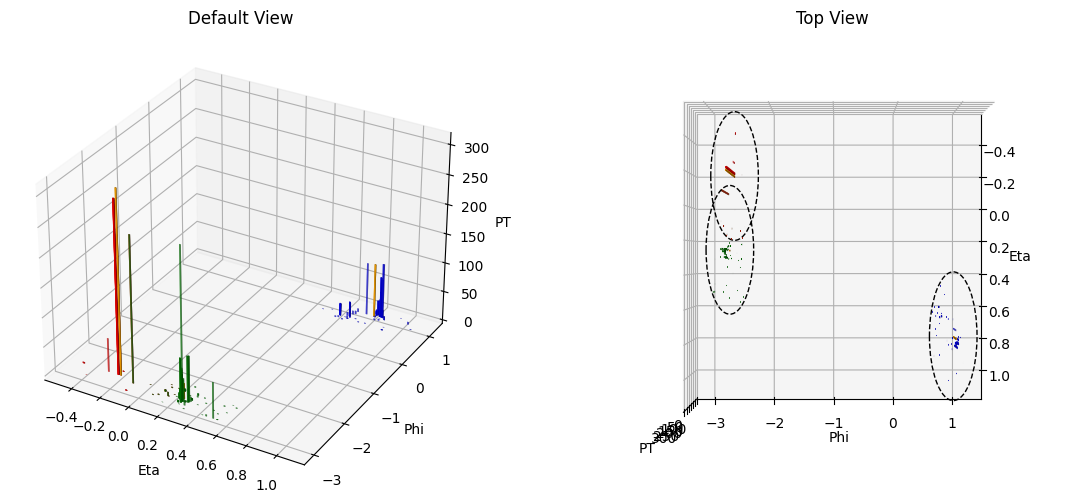

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

event = 520
# 示例数据，替换为你的实际数据
print('jet num:', sgsl_1j_Eho_1l[event][18])
print('tau:', sgsl_1j_Eho_1l[event][22])

PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT for the first dataset
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta for the first dataset
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi for the first dataset

PT2 = sgsl_1j_Eho_1l[event][23]  # Particle PT for the second dataset (jets)
Eta2 = sgsl_1j_Eho_1l[event][24]  # Particle Eta for the second dataset (jets)
phi2 = sgsl_1j_Eho_1l[event][25]  # Particle phi for the second dataset (jets)

dx = dy = 0.05

Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)

# 查找半径0.4内的粒子
selected_particles = []
for eta, phi in zip(Eta2, phi2):
    distances = np.sqrt((Eta1 - eta)**2 + (phi1 - phi)**2)
    mask = distances < 0.4
    selected_particles.append({
        'Eta': Eta1[mask],
        'Phi': phi1[mask],
        'PT': PT1[mask]
    })

# 定义绘制圆的函数
def plot_circle(ax, x_center, y_center, radius, color):
    circle = plt.Circle((x_center, y_center), radius, color=color, fill=False, linestyle='--')
    ax.add_patch(circle)
    art3d.pathpatch_2d_to_3d(circle, z=0, zdir="z")
#################################################################################
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

# 绘制所有粒子
ax1.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
colors = ['red', 'blue', 'green']
for i, particles in enumerate(selected_particles):
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：俯视图
ax2 = fig.add_subplot(122, projection='3d')

# 绘制所有粒子
ax2.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
for i, particles in enumerate(selected_particles):
    ax2.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_zlabel('PT')
ax2.set_title('Top View')

# 设置俯视图视角
ax2.view_init(elev=90, azim=0)

# 在每个喷注位置绘制半径为0.4的虚线圆
for eta, phi in zip(Eta2, phi2):
    plot_circle(ax2, eta, phi, 0.4, 'black')

plt.show()

#################################################################################
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

dx2 = dy2 = 0.01

for i, particles in enumerate(selected_particles):
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx2, dy2, particles['PT'], color=colors[i], alpha=0.5, shade=True)
    
ax1.bar3d(Eta2, phi2, np.zeros_like(PT2), dx2, dy2, PT2, color='orange', alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：俯视图
ax2 = fig.add_subplot(122, projection='3d')

for i, particles in enumerate(selected_particles):
    ax2.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx2, dy2, particles['PT'], color=colors[i], alpha=0.5, shade=True)
    
ax2.bar3d(Eta2, phi2, np.zeros_like(PT2), dx2, dy2, PT2, color='orange', alpha=1, shade=True)

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_zlabel('PT')
ax2.set_title('Top View')

# 设置俯视图视角
ax2.view_init(elev=90, azim=0)

# 在每个喷注位置绘制半径为0.4的虚线圆
for eta, phi in zip(Eta2, phi2):
    plot_circle(ax2, eta, phi, 0.4, 'black')

plt.show()


jet num: 2
tau: [[0.18573014 0.         0.         0.         0.        ]
 [0.09206735 0.03363442 0.01345889 0.00212543 0.        ]]


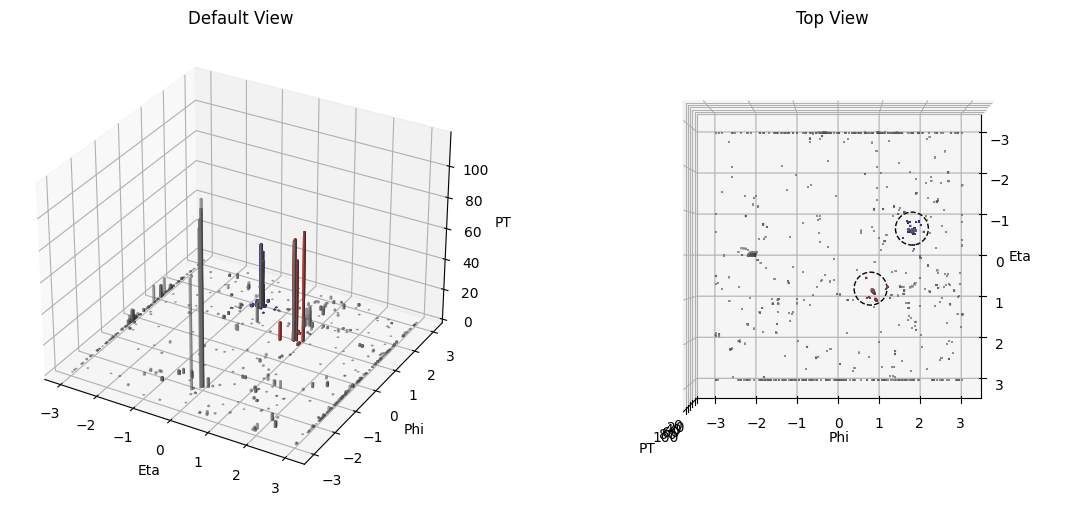

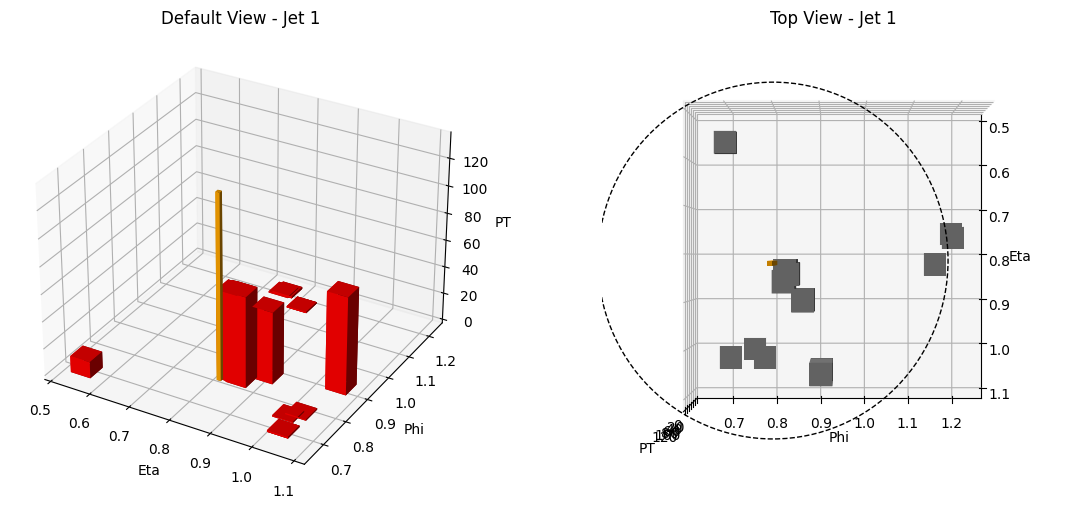

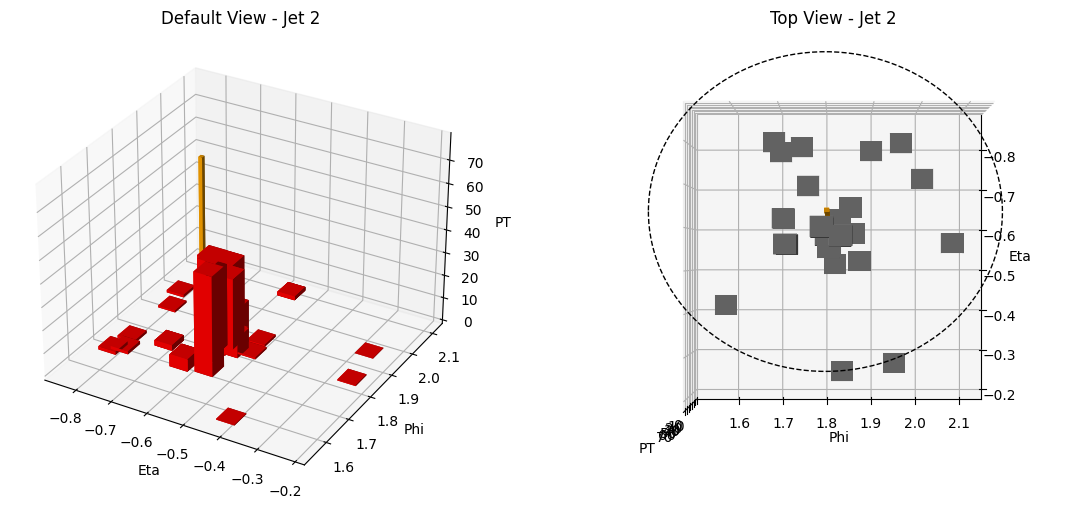

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

event = 999
# 示例数据，替换为你的实际数据
print('jet num:', sgsl_1j_Eho_1l[event][18])
print('tau:', sgsl_1j_Eho_1l[event][22])

PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT for the first dataset
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta for the first dataset
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi for the first dataset

PT2 = sgsl_1j_Eho_1l[event][23]  # Particle PT for the second dataset (jets)
Eta2 = sgsl_1j_Eho_1l[event][24]  # Particle Eta for the second dataset (jets)
phi2 = sgsl_1j_Eho_1l[event][25]  # Particle phi for the second dataset (jets)

dx = dy = 0.05
dx2 = dy2 = 0.01

Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)

# 查找半径0.4内的粒子
selected_particles = []
for eta, phi in zip(Eta2, phi2):
    distances = np.sqrt((Eta1 - eta)**2 + (phi1 - phi)**2)
    mask = distances < 0.4
    selected_particles.append({
        'Eta': Eta1[mask],
        'Phi': phi1[mask],
        'PT': PT1[mask]
    })

# 定义绘制圆的函数
def plot_circle(ax, x_center, y_center, radius, color):
    circle = plt.Circle((x_center, y_center), radius, color=color, fill=False, linestyle='--')
    ax.add_patch(circle)
    art3d.pathpatch_2d_to_3d(circle, z=0, zdir="z")
    
# 全体数据绘制
#########################################################################
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

# 绘制所有粒子
ax1.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
colors = ['red', 'blue', 'green']
for i, particles in enumerate(selected_particles):
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：俯视图
ax2 = fig.add_subplot(122, projection='3d')

# 绘制所有粒子
ax2.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
for i, particles in enumerate(selected_particles):
    ax2.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_zlabel('PT')
ax2.set_title('Top View')

# 设置俯视图视角
ax2.view_init(elev=90, azim=0)

# 在每个喷注位置绘制半径为0.4的虚线圆
for eta, phi in zip(Eta2, phi2):
    plot_circle(ax2, eta, phi, 0.4, 'black')

plt.show()
#########################################################################

# 绘制多张图
for i, (eta, phi) in enumerate(zip(Eta2, phi2)):
    fig = plt.figure(figsize=(14, 6))

    # 子图1：默认视角
    ax1 = fig.add_subplot(121, projection='3d')

    # 绘制被选中的粒子
    particles = selected_particles[i]
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color='red', alpha=1, shade=True)
    ax1.bar3d(eta, phi, 0, dx2, dy2, PT2[i]*2, color='orange', alpha=1, shade=True)
    ax1.set_xlabel('Eta')
    ax1.set_ylabel('Phi')
    ax1.set_zlabel('PT')
    ax1.set_title(f'Default View - Jet {i + 1}')

    # 子图2：俯视图
    ax2 = fig.add_subplot(122, projection='3d')

    # 绘制被选中的粒子
    ax2.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color='gray', alpha=1, shade=True)
    ax2.bar3d(eta, phi, 0, dx2, dy2, PT2[i]*2, color='orange', alpha=1, shade=True)
    ax2.set_xlabel('Eta')
    ax2.set_ylabel('Phi')
    ax2.set_zlabel('PT')
    ax2.set_title(f'Top View - Jet {i + 1}')

    # 设置俯视图视角
    ax2.view_init(elev=90, azim=0)

    # 在喷注位置绘制半径为0.4的虚线圆
    plot_circle(ax2, eta, phi, 0.4, 'black')

    plt.show()


jet num: 1
tau: [[0.10153245 0.00581869 0.         0.         0.        ]]


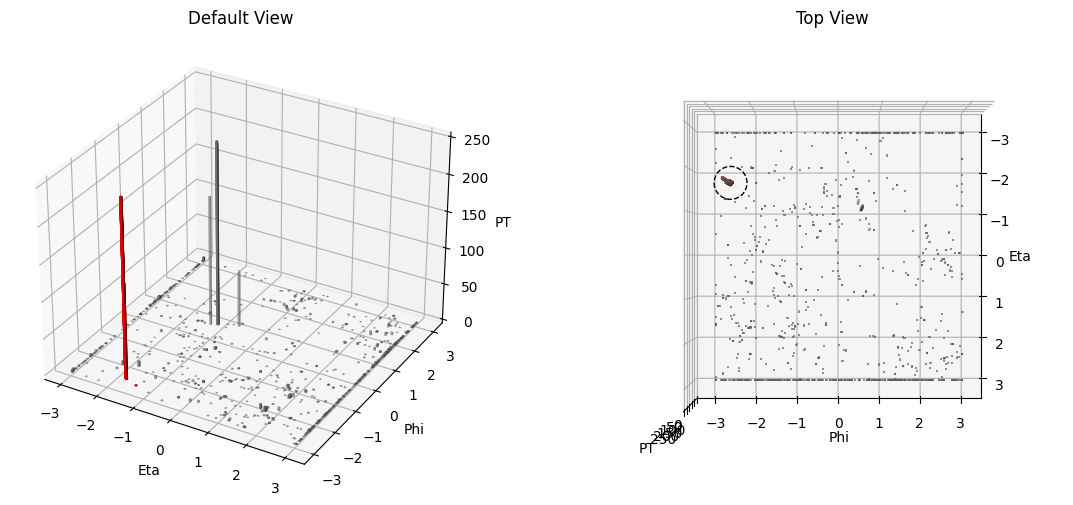

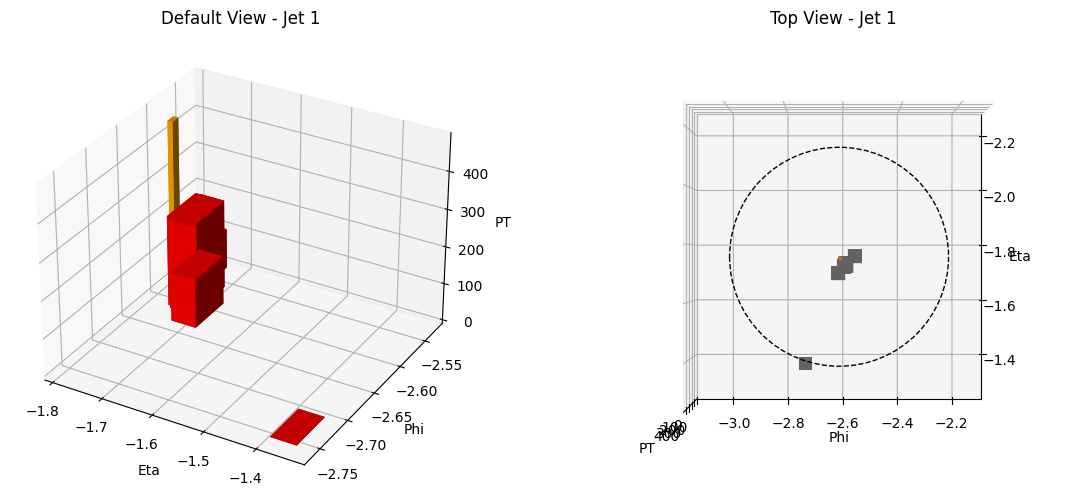

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

event = 222
# 示例数据，替换为你的实际数据
print('jet num:', sgsl_1j_Eho_1l[event][18])
print('tau:', sgsl_1j_Eho_1l[event][22])

PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT for the first dataset
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta for the first dataset
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi for the first dataset

PT2 = sgsl_1j_Eho_1l[event][23]  # Particle PT for the second dataset (jets)
Eta2 = sgsl_1j_Eho_1l[event][24]  # Particle Eta for the second dataset (jets)
phi2 = sgsl_1j_Eho_1l[event][25]  # Particle phi for the second dataset (jets)

dx = dy = 0.05
dx2 = dy2 = 0.01

Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)

# 查找半径0.4内的粒子
selected_particles = []
for eta, phi in zip(Eta2, phi2):
    distances = np.sqrt((Eta1 - eta)**2 + (phi1 - phi)**2)
    mask = distances < 0.4
    selected_particles.append({
        'Eta': Eta1[mask],
        'Phi': phi1[mask],
        'PT': PT1[mask]
    })

# 定义绘制圆的函数
def plot_circle(ax, x_center, y_center, radius, color):
    circle = plt.Circle((x_center, y_center), radius, color=color, fill=False, linestyle='--')
    ax.add_patch(circle)
    art3d.pathpatch_2d_to_3d(circle, z=0, zdir="z")
    
# 全体数据绘制
#########################################################################
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

# 绘制所有粒子
ax1.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
colors = ['red', 'blue', 'green']
for i, particles in enumerate(selected_particles):
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：俯视图
ax2 = fig.add_subplot(122, projection='3d')

# 绘制所有粒子
ax2.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
for i, particles in enumerate(selected_particles):
    ax2.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_zlabel('PT')
ax2.set_title('Top View')

# 设置俯视图视角
ax2.view_init(elev=90, azim=0)

# 在每个喷注位置绘制半径为0.4的虚线圆
for eta, phi in zip(Eta2, phi2):
    plot_circle(ax2, eta, phi, 0.4, 'black')

plt.show()
#########################################################################

# 绘制多张图
for i, (eta, phi) in enumerate(zip(Eta2, phi2)):
    fig = plt.figure(figsize=(14, 6))

    # 子图1：默认视角
    ax1 = fig.add_subplot(121, projection='3d')

    # 绘制被选中的粒子
    particles = selected_particles[i]
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color='red', alpha=1, shade=True)
    ax1.bar3d(eta, phi, 0, dx2, dy2, PT2[i]*2, color='orange', alpha=1, shade=True)
    ax1.set_xlabel('Eta')
    ax1.set_ylabel('Phi')
    ax1.set_zlabel('PT')
    ax1.set_title(f'Default View - Jet {i + 1}')

    # 子图2：俯视图
    ax2 = fig.add_subplot(122, projection='3d')

    # 绘制被选中的粒子
    ax2.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color='gray', alpha=1, shade=True)
    ax2.bar3d(eta, phi, 0, dx2, dy2, PT2[i]*2, color='orange', alpha=1, shade=True)
    ax2.set_xlabel('Eta')
    ax2.set_ylabel('Phi')
    ax2.set_zlabel('PT')
    ax2.set_title(f'Top View - Jet {i + 1}')
    ax2.set_xlim(eta-0.5, eta+0.5)  # 设置Eta的范围
    ax2.set_ylim(phi-0.5, phi+0.5)
    # 设置俯视图视角
    ax2.view_init(elev=90, azim=0)

    # 在喷注位置绘制半径为0.4的虚线圆
    plot_circle(ax2, eta, phi, 0.4, 'black')

    plt.show()


jet num: 1
tau: [[0.10153245 0.00581869 0.         0.         0.        ]]
Ehad/EEM: [0.00933252]


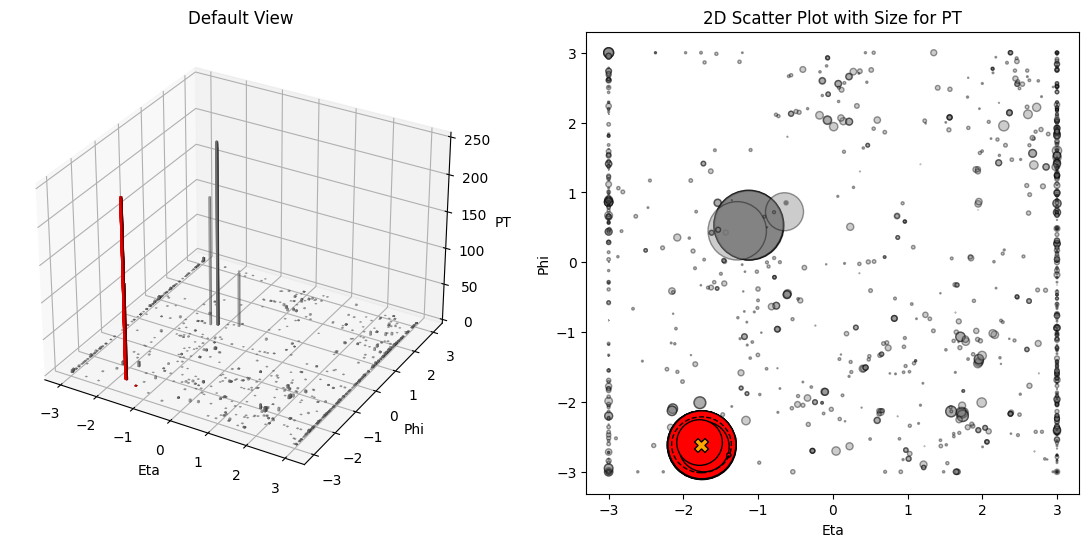

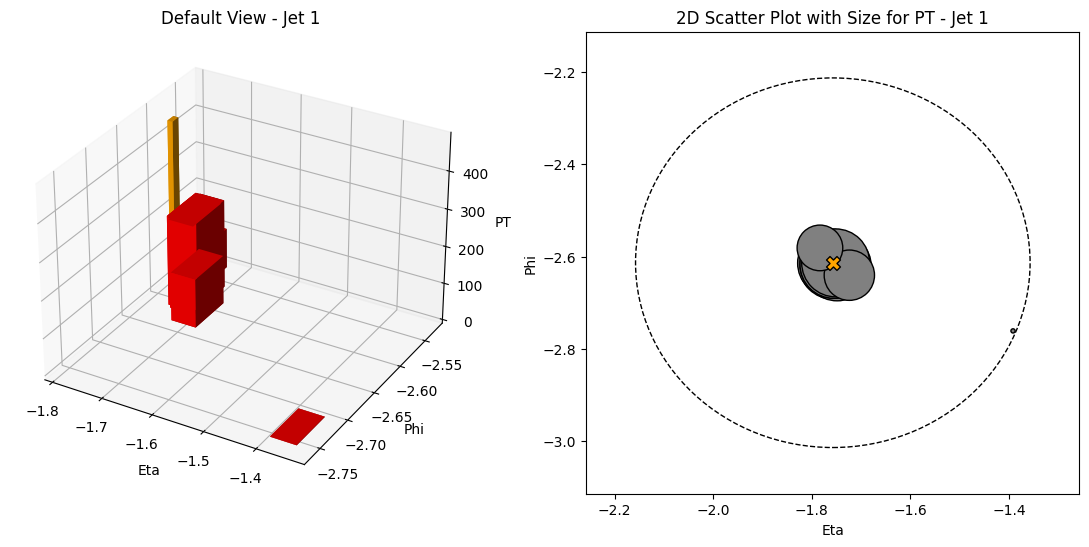

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

event = 222
# 示例数据，替换为你的实际数据
print('jet num:', sgsl_1j_Eho_1l[event][18])
print('tau:', sgsl_1j_Eho_1l[event][22])
print('Ehad/EEM:', sgsl_1j_Eho_1l[event][19])

PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT for the first dataset
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta for the first dataset
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi for the first dataset

PT2 = sgsl_1j_Eho_1l[event][23]  # Particle PT for the second dataset (jets)
Eta2 = sgsl_1j_Eho_1l[event][24]  # Particle Eta for the second dataset (jets)
phi2 = sgsl_1j_Eho_1l[event][25]  # Particle phi for the second dataset (jets)

dx = dy = 0.05
dx2 = dy2 = 0.01

Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)

# 查找半径0.4内的粒子
selected_particles = []
for eta, phi in zip(Eta2, phi2):
    distances = np.sqrt((Eta1 - eta)**2 + (phi1 - phi)**2)
    mask = distances < 0.4
    selected_particles.append({
        'Eta': Eta1[mask],
        'Phi': phi1[mask],
        'PT': PT1[mask]
    })

# 定义绘制圆的函数
def plot_circle(ax, x_center, y_center, radius, color):
    circle = plt.Circle((x_center, y_center), radius, color=color, fill=False, linestyle='--')
    ax.add_patch(circle)

# 全体数据绘制
#########################################################################
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

# 绘制所有粒子
ax1.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
colors = ['red', 'blue', 'green']
for i, particles in enumerate(selected_particles):
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：2D散点图
ax2 = fig.add_subplot(122)

# 绘制所有粒子
ax2.scatter(Eta1, phi1, s=PT1*10, c='gray', alpha=0.4, edgecolor='k')

# 用不同颜色绘制被选中的粒子
for i, particles in enumerate(selected_particles):
    ax2.scatter(particles['Eta'], particles['Phi'], s=particles['PT']*10, c=colors[i], alpha=1, edgecolor='k')

# 在每个喷注位置绘制半径为0.4的虚线圆
for eta, phi in zip(Eta2, phi2):
    plot_circle(ax2, eta, phi, 0.4, 'black')

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_title('2D Scatter Plot with Size for PT')

# 使用星号表示喷注位置
ax2.scatter(Eta2, phi2, s=100, c='orange', alpha=1, edgecolor='k', marker='X')

plt.show()
#########################################################################

# 绘制多张图
for i, (eta, phi) in enumerate(zip(Eta2, phi2)):
    fig = plt.figure(figsize=(14, 6))

    # 子图1：默认视角
    ax1 = fig.add_subplot(121, projection='3d')

    # 绘制被选中的粒子
    particles = selected_particles[i]
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color='red', alpha=1, shade=True)
    ax1.bar3d(eta, phi, 0, dx2, dy2, PT2[i]*2, color='orange', alpha=1, shade=True)
    ax1.set_xlabel('Eta')
    ax1.set_ylabel('Phi')
    ax1.set_zlabel('PT')
    ax1.set_title(f'Default View - Jet {i + 1}')

    # 子图2：2D散点图
    ax2 = fig.add_subplot(122)

    # 绘制被选中的粒子
    ax2.scatter(particles['Eta'], particles['Phi'], s=particles['PT']*10, c='gray', alpha=1, edgecolor='k')
    ax2.scatter(eta, phi, s=100, c='orange', alpha=1, edgecolor='k', marker='X')

    # 设置范围
    ax2.set_xlim(eta-0.5, eta+0.5)  # 设置Eta的范围
    ax2.set_ylim(phi-0.5, phi+0.5)  # 设置Phi的范围

    ax2.set_xlabel('Eta')
    ax2.set_ylabel('Phi')
    ax2.set_title(f'2D Scatter Plot with Size for PT - Jet {i + 1}')

    # 在喷注位置绘制半径为0.4的虚线圆
    plot_circle(ax2, eta, phi, 0.4, 'black')

    plt.show()


jet num: 1
tau: [[0.21036726 0.00222584 0.         0.         0.        ]]
Ehad/EEM: [0.00341022]
FracPt: [[0. 0. 0. 0. 0.]]
TrimmedP4: [TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]
PrunedP4: [TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]
SoftDroppedP4: [TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]


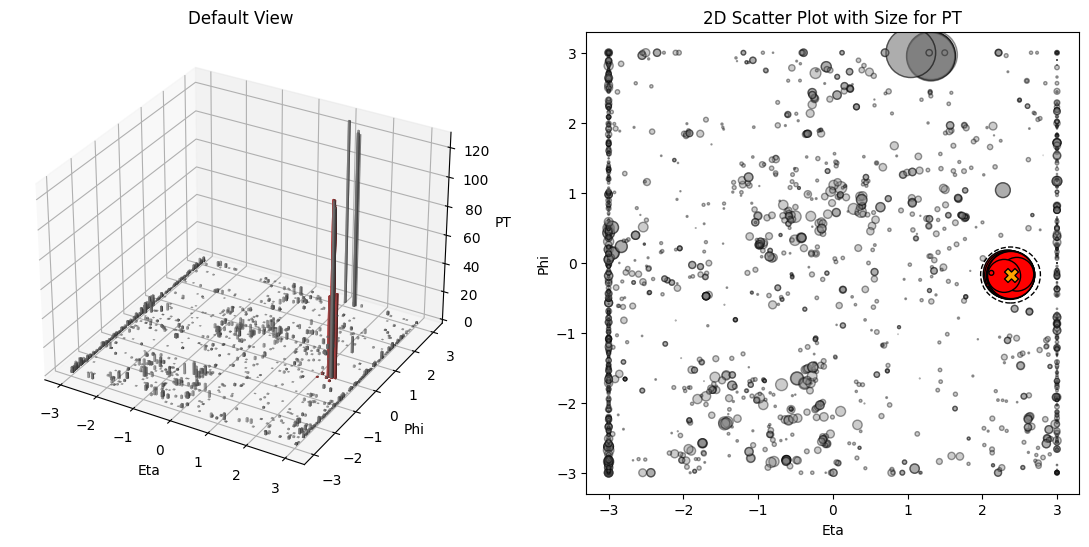

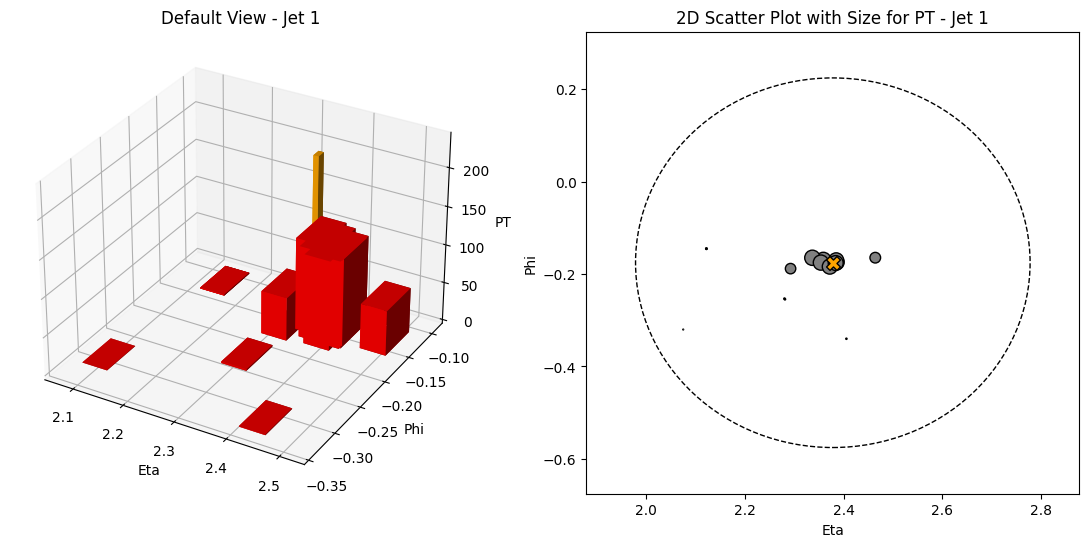

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

event = 365
# 示例数据，替换为你的实际数据
print('jet num:', sgsl_1j_Eho_1l[event][18])
print('tau:', sgsl_1j_Eho_1l[event][22])
print('Ehad/EEM:', sgsl_1j_Eho_1l[event][19])

print('FracPt:', sgsl_1j_Eho_1l[event][32])
print('TrimmedP4:', sgsl_1j_Eho_1l[event][33])
print('PrunedP4:', sgsl_1j_Eho_1l[event][34])
print('SoftDroppedP4:', sgsl_1j_Eho_1l[event][35])

PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT for the first dataset
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta for the first dataset
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi for the first dataset

PT2 = sgsl_1j_Eho_1l[event][23]  # Particle PT for the second dataset (jets)
Eta2 = sgsl_1j_Eho_1l[event][24]  # Particle Eta for the second dataset (jets)
phi2 = sgsl_1j_Eho_1l[event][25]  # Particle phi for the second dataset (jets)

dx = dy = 0.05
dx2 = dy2 = 0.01

Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)

# 查找半径0.4内的粒子
selected_particles = []
for eta, phi in zip(Eta2, phi2):
    distances = np.sqrt((Eta1 - eta)**2 + (phi1 - phi)**2)
    mask = distances < 0.4
    selected_particles.append({
        'Eta': Eta1[mask],
        'Phi': phi1[mask],
        'PT': PT1[mask]
    })

# 定义绘制圆的函数
def plot_circle(ax, x_center, y_center, radius, color):
    circle = plt.Circle((x_center, y_center), radius, color=color, fill=False, linestyle='--')
    ax.add_patch(circle)

# 全体数据绘制
#########################################################################
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

# 绘制所有粒子
ax1.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
colors = ['red', 'blue', 'green']
for i, particles in enumerate(selected_particles):
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：2D散点图
ax2 = fig.add_subplot(122)

# 绘制所有粒子
ax2.scatter(Eta1, phi1, s=PT1*10, c='gray', alpha=0.4, edgecolor='k')

# 用不同颜色绘制被选中的粒子
for i, particles in enumerate(selected_particles):
    ax2.scatter(particles['Eta'], particles['Phi'], s=particles['PT']*10, c=colors[i], alpha=1, edgecolor='k')

# 在每个喷注位置绘制半径为0.4的虚线圆
for eta, phi in zip(Eta2, phi2):
    plot_circle(ax2, eta, phi, 0.4, 'black')

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_title('2D Scatter Plot with Size for PT')

# 使用星号表示喷注位置
ax2.scatter(Eta2, phi2, s=100, c='orange', alpha=1, edgecolor='k', marker='X')

plt.show()
#########################################################################

# 绘制多张图
for i, (eta, phi) in enumerate(zip(Eta2, phi2)):
    fig = plt.figure(figsize=(14, 6))

    # 子图1：默认视角
    ax1 = fig.add_subplot(121, projection='3d')

    # 绘制被选中的粒子
    particles = selected_particles[i]
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color='red', alpha=1, shade=True)
    ax1.bar3d(eta, phi, 0, dx2, dy2, PT2[i]*2, color='orange', alpha=1, shade=True)
    ax1.set_xlabel('Eta')
    ax1.set_ylabel('Phi')
    ax1.set_zlabel('PT')
    ax1.set_title(f'Default View - Jet {i + 1}')

    # 子图2：2D散点图
    ax2 = fig.add_subplot(122)

    # 绘制被选中的粒子
    ax2.scatter(particles['Eta'], particles['Phi'], s=particles['PT'], c='gray', alpha=1, edgecolor='k')
    ax2.scatter(eta, phi, s=100, c='orange', alpha=1, edgecolor='k', marker='X')

    # 设置范围
    ax2.set_xlim(eta-0.5, eta+0.5)  # 设置Eta的范围
    ax2.set_ylim(phi-0.5, phi+0.5)  # 设置Phi的范围

    ax2.set_xlabel('Eta')
    ax2.set_ylabel('Phi')
    ax2.set_title(f'2D Scatter Plot with Size for PT - Jet {i + 1}')

    # 在喷注位置绘制半径为0.4的虚线圆
    plot_circle(ax2, eta, phi, 0.4, 'black')

    plt.show()


In [92]:
total_events = len(sgsl_1j_Eho_1l)

# 存储满足条件的事件索引
events_with_low_Ehad_EEM = []

# 遍历所有事件
for event in range(total_events):
    # 获取事件中所有喷注的 Ehad/EEM 值
    for i in range(len(sgsl_1j_Eho_1l[event][19])):
        Ehad_over_EEM = sgsl_1j_Eho_1l[event][19][i]
        tau_values = sgsl_1j_Eho_1l[event][22][i]
        non_zero_count = np.count_nonzero(tau_values)
    # 检查是否有任何喷注的 Ehad/EEM < 0.02
        if 0 <Ehad_over_EEM < 0.02 and non_zero_count==2 and tau_values[1]<tau_values[0]:
            events_with_low_Ehad_EEM.append(event)
print(events_with_low_Ehad_EEM)
print('//////////////////////////////////////////////////////////////')

events_with_low_Ehad_EEM = []

# 遍历所有事件
for event in range(total_events):
    # 获取事件中所有喷注的 Ehad/EEM 值
    for i in range(len(sgsl_1j_Eho_1l[event][19])):
        Ehad_over_EEM = sgsl_1j_Eho_1l[event][19][i]
        tau_values = sgsl_1j_Eho_1l[event][22][i]
        non_zero_count = np.count_nonzero(tau_values)
    # 检查是否有任何喷注的 Ehad/EEM < 0.02
        if 0 <Ehad_over_EEM < 0.02 and non_zero_count==2 and tau_values[1]/tau_values[0]<0.05 :
            events_with_low_Ehad_EEM.append(event)
print(events_with_low_Ehad_EEM)

[7, 33, 39, 77, 83, 106, 117, 120, 125, 189, 206, 221, 222, 230, 281, 292, 314, 362, 365, 391, 400, 424, 430, 509, 518, 529, 529, 544, 547, 558, 576, 588, 611, 624, 644, 646, 656, 683, 696, 720, 757, 759, 795, 805, 816, 818, 819, 832, 867, 885, 906, 926, 943, 950, 970, 983, 988, 995, 998, 1003, 1007, 1022, 1036, 1040, 1062, 1091, 1103, 1106, 1129, 1147, 1169, 1214, 1219, 1228, 1313, 1329, 1339, 1339, 1340, 1354, 1400, 1403, 1404, 1422, 1458, 1482, 1507, 1550, 1561, 1581, 1645, 1668, 1698, 1744, 1755, 1760, 1784, 1818, 1836, 1868, 1894, 1898, 1904, 1931, 1941, 1955, 1991, 2028, 2031, 2050, 2051, 2055, 2068, 2075, 2113, 2145, 2164, 2190, 2210, 2220, 2233, 2262, 2273, 2291, 2306, 2307, 2343, 2345, 2360, 2365, 2449, 2474, 2490, 2556, 2574, 2598, 2604, 2608, 2655, 2672, 2696, 2706, 2729, 2736, 2750, 2752, 2782, 2798, 2816, 2909, 2912, 2930, 2945, 2957, 2967, 3033, 3067, 3071, 3102, 3123, 3151, 3171, 3173, 3177, 3179, 3185, 3229, 3234, 3267, 3281, 3287, 3329]
////////////////////////////////

jet num: 1
tau: [[0.07078999 0.00298781 0.         0.         0.        ]]
Ehad/EEM: [0.00528171]
FracPt: [[0. 0. 0. 0. 0.]]
TrimmedP4: [TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]
PrunedP4: [TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]
SoftDroppedP4: [TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]


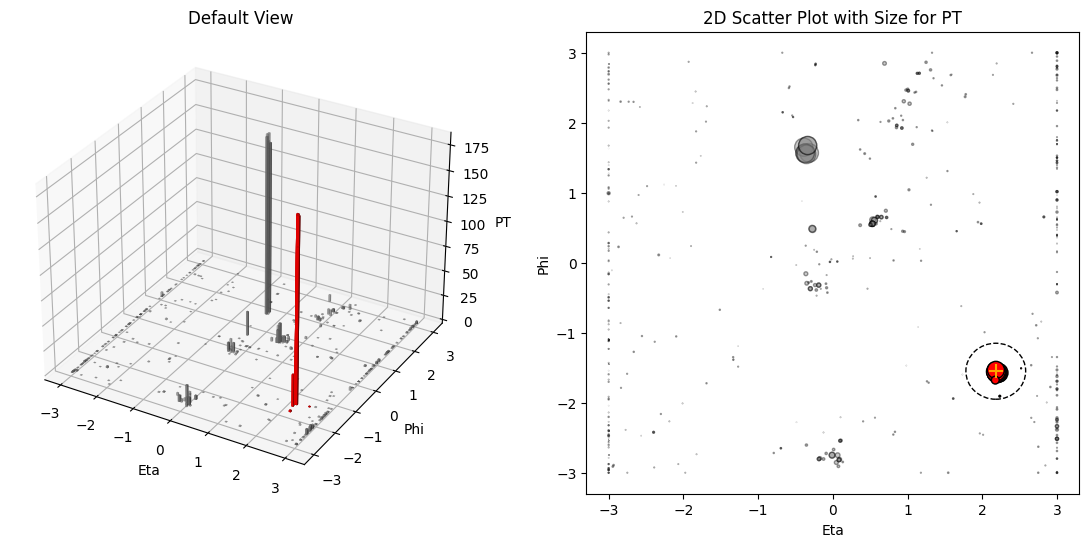

Jet 1 包含的粒子编号: [9000005 9000005 9000005 9000005      21 9000005      22      22     211]


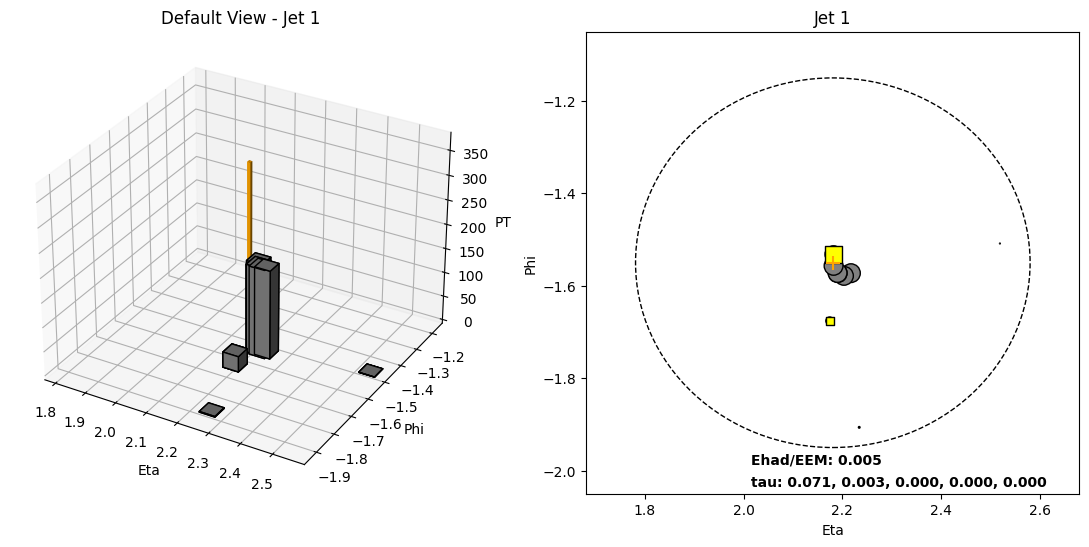

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

event = 683
#2556 365 3033 2909 33 558


#588
# 示例数据，替换为你的实际数据
print('jet num:', sgsl_1j_Eho_1l[event][18])
print('tau:', sgsl_1j_Eho_1l[event][22])
print('Ehad/EEM:', sgsl_1j_Eho_1l[event][19])
print('FracPt:', sgsl_1j_Eho_1l[event][32])
print('TrimmedP4:', sgsl_1j_Eho_1l[event][33])
print('PrunedP4:', sgsl_1j_Eho_1l[event][34])
print('SoftDroppedP4:', sgsl_1j_Eho_1l[event][35])

PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT for the first dataset
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta for the first dataset
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi for the first dataset
particle_ids = sgsl_1j_Eho_1l[event][28]  # Particle IDs

PT2 = sgsl_1j_Eho_1l[event][23]  # Particle PT for the second dataset (jets)
Eta2 = sgsl_1j_Eho_1l[event][24]  # Particle Eta for the second dataset (jets)
phi2 = sgsl_1j_Eho_1l[event][25]  # Particle phi for the second dataset (jets)

dx = dy = 0.05
dx2 = dy2 = 0.01

Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)

# 查找半径0.4内的粒子
selected_particles = []
for eta, phi in zip(Eta2, phi2):
    distances = np.sqrt((Eta1 - eta)**2 + (phi1 - phi)**2)
    mask = distances < 0.4
    selected_particles.append({
        'Eta': Eta1[mask],
        'Phi': phi1[mask],
        'PT': PT1[mask],
        'IDs': particle_ids[mask]
    })

# 定义绘制圆的函数
def plot_circle(ax, x_center, y_center, radius, color):
    circle = plt.Circle((x_center, y_center), radius, color=color, fill=False, linestyle='--')
    ax.add_patch(circle)

# 全体数据绘制
#########################################################################
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

# 绘制所有粒子
ax1.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
colors = ['red', 'blue', 'green','yellow']
for i, particles in enumerate(selected_particles):
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color=colors[i], alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：2D散点图
ax2 = fig.add_subplot(122)

# 绘制所有粒子
ax2.scatter(Eta1, phi1, s=PT1, c='gray', alpha=0.4, edgecolor='k')

# 用不同颜色绘制被选中的粒子
for i, particles in enumerate(selected_particles):
    ax2.scatter(particles['Eta'], particles['Phi'], s=particles['PT'], c=colors[i], alpha=1, edgecolor='k')

# 在每个喷注位置绘制半径为0.4的虚线圆
for eta, phi in zip(Eta2, phi2):
    plot_circle(ax2, eta, phi, 0.4, 'black')

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_title('2D Scatter Plot with Size for PT')

ax2.scatter(Eta2, phi2, s=100, c='orange', alpha=1, edgecolor='k', marker='+')

plt.show()
#########################################################################

# 绘制多张图
for i, (eta, phi) in enumerate(zip(Eta2, phi2)):
    fig = plt.figure(figsize=(14, 6))

    # 子图1：默认视角
    ax1 = fig.add_subplot(121, projection='3d')

    # 绘制被选中的粒子
    particles = selected_particles[i]
    
    photon_mask = particles['IDs'] == 22  # 光子的 PID 编号为 22
    ax1.bar3d(particles['Eta'][photon_mask], particles['Phi'][photon_mask], np.zeros_like(particles['PT'][photon_mask]), dx, dy, particles['PT'][photon_mask], color='orange', alpha=1, shade=True, edgecolor = 'black')
    
    ax1.bar3d(particles['Eta'], particles['Phi'], np.zeros_like(particles['PT']), dx, dy, particles['PT'], color='gray', alpha=1, shade=True ,edgecolor = 'black')
    
    
    
    ax1.bar3d(eta, phi, 0, dx2, dy2, PT2[i]*2, color='orange', alpha=1, shade=True)
    
    ax1.set_xlabel('Eta')
    ax1.set_ylabel('Phi')
    ax1.set_zlabel('PT')
    ax1.set_title(f'Default View - Jet {i + 1}')
    
    ax1.set_xlim(eta-0.4, eta+0.4)  # 设置Eta的范围
    ax1.set_ylim(phi-0.4, phi+0.4)  # 设置Phi的范围

    # 子图2：2D散点图
    ax2 = fig.add_subplot(122)

    # 绘制被选中的粒子
    ax2.scatter(particles['Eta'], particles['Phi'], s=particles['PT'], c='gray', alpha=1, edgecolor='k')
    
    # 标注光子位置
    photon_mask = particles['IDs'] == 22  # 光子的 PID 编号为 22
    ax2.scatter(particles['Eta'][photon_mask], particles['Phi'][photon_mask], s=particles['PT'][photon_mask], c='yellow', alpha=1, edgecolor='k', marker='s')

    ax2.scatter(eta, phi, s=100, c='orange', alpha=1, edgecolor='k', marker='+')

    # 设置范围
    ax2.set_xlim(eta-0.5, eta+0.5)  # 设置Eta的范围
    ax2.set_ylim(phi-0.5, phi+0.5)  # 设置Phi的范围

    ax2.set_xlabel('Eta')
    ax2.set_ylabel('Phi')
    ax2.set_title(f'Jet {i + 1}')
    
    tau_value = sgsl_1j_Eho_1l[event][22][i]  # 这里是一个数组
    ax2.annotate(f'tau: {tau_value[0]:.3f}, {tau_value[1]:.3f}, {tau_value[2]:.3f}, {tau_value[3]:.3f}, {tau_value[4]:.3f}', xy=(eta-0.18, phi-0.5), xytext=(5, 5),
                 textcoords='offset points', ha='left', fontsize=10, color='black', weight='bold',
                 )
    ax2.annotate(f'Ehad/EEM: {sgsl_1j_Eho_1l[event][19][i]:.3f}', xy=(eta-0.18, phi-0.45), xytext=(5, 5),
                 textcoords='offset points', ha='left', fontsize=10, color='black', weight='bold',
                 )
    plot_circle(ax2, eta, phi, 0.4, 'black')

    # 打印被选中的粒子编号
    print(f'Jet {i + 1} 包含的粒子编号: {particles["IDs"]}')

    plt.show()


jet num: 3
tau: [[0.09084684 0.00355512 0.         0.         0.        ]
 [0.15487887 0.10774605 0.07160755 0.04792526 0.03088027]
 [0.3120232  0.1752051  0.12597178 0.06912988 0.0451658 ]]
Ehad/EEM: [0.00575859 3.6669803  0.974469  ]
FracPt: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
TrimmedP4: [TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) ... TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]
PrunedP4: [TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) ... TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]
SoftDroppedP4: [TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) ... TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]


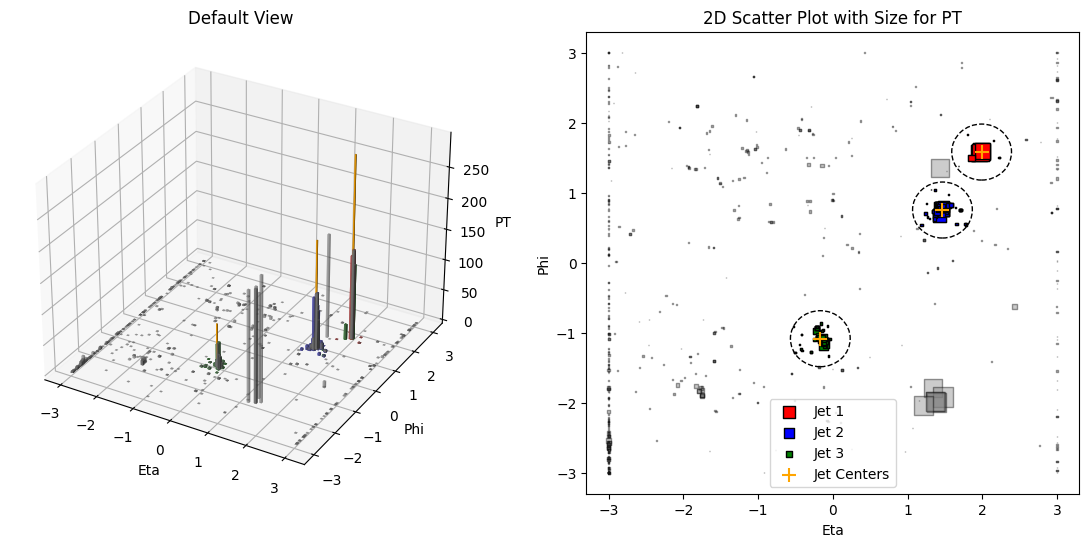

Jet 1 包含的粒子编号: [9000005 9000005 9000005      21      21 9000005      21      22      22
     211     211]


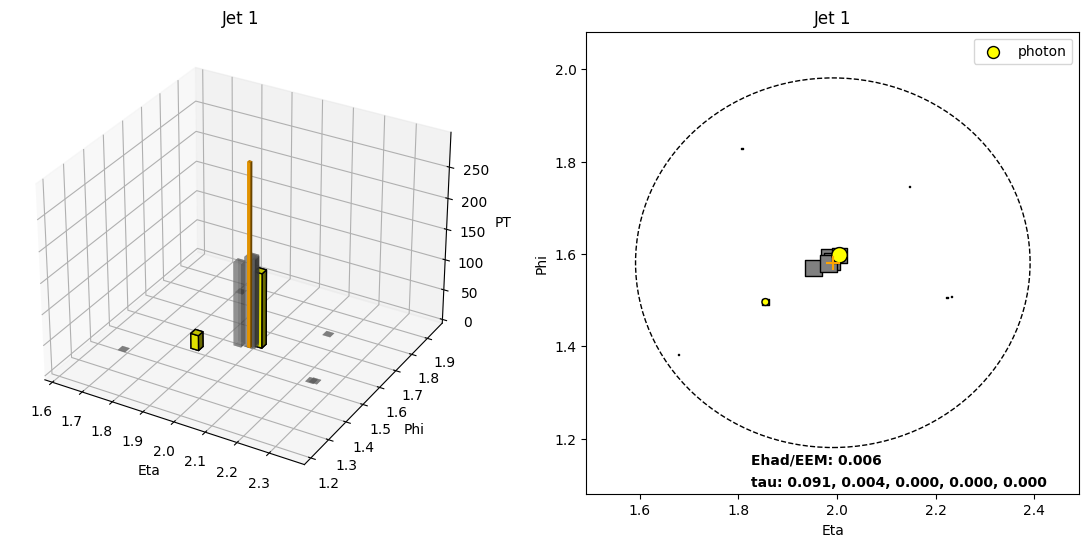

Jet 2 包含的粒子编号: [   21    21    21    21    21    21    21    21    21    21    21    21
    21    21    21    21    21    21    21    21    21    21    21    21
    21    21    21    21    21    21    21    21   111   111  -211   213
  2112 -2212   211  -211   113   211   211   111  -211    22    22    22
  -211    22    22]


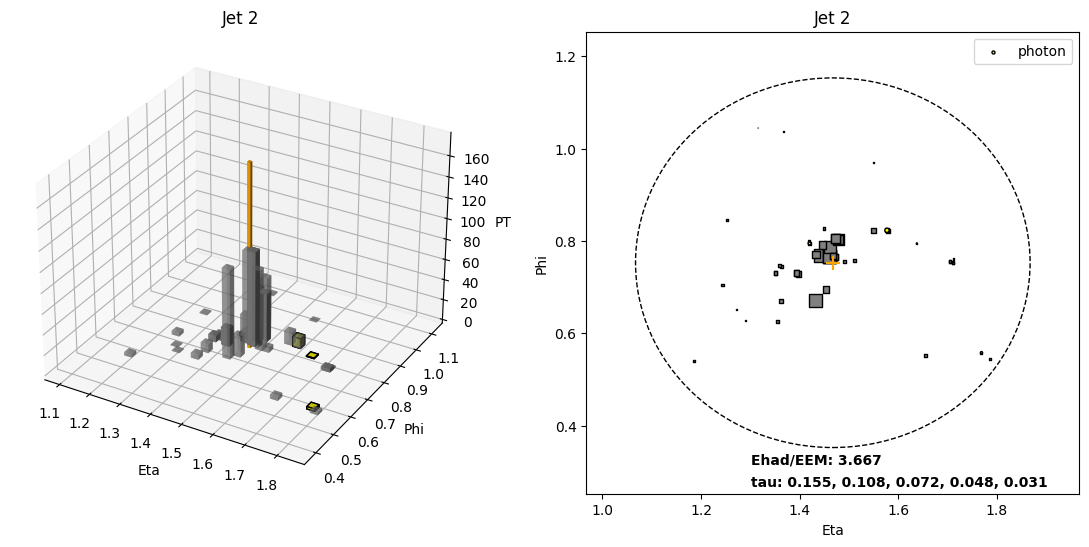

Jet 3 包含的粒子编号: [   2    2    2   21   21    2   21   21   21   21   21    2   21   21
   21   21    2   21   21   21  211 -213  211 -211  223  113  321 -311
 -211  111  211 -211  310  111   22   22   22  111  111   22   22   22
   22   22]


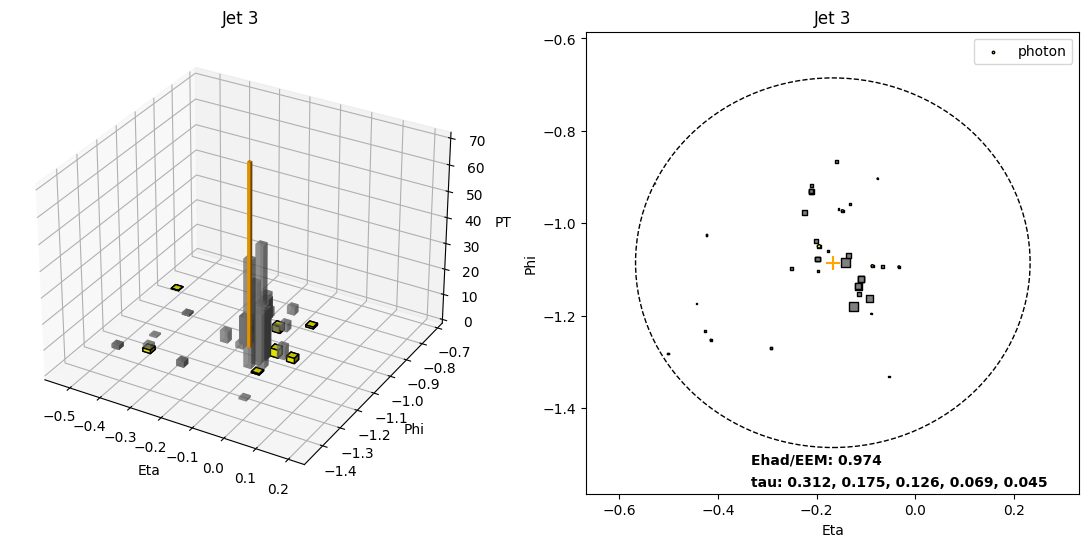

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

event = 588

# 示例数据，替换为你的实际数据
print('jet num:', sgsl_1j_Eho_1l[event][18])
print('tau:', sgsl_1j_Eho_1l[event][22])
print('Ehad/EEM:', sgsl_1j_Eho_1l[event][19])
print('FracPt:', sgsl_1j_Eho_1l[event][32])
print('TrimmedP4:', sgsl_1j_Eho_1l[event][33])
print('PrunedP4:', sgsl_1j_Eho_1l[event][34])
print('SoftDroppedP4:', sgsl_1j_Eho_1l[event][35])

PT1 = sgsl_1j_Eho_1l[event][29]  # Particle PT for the first dataset
Eta1 = sgsl_1j_Eho_1l[event][30]  # Particle Eta for the first dataset
phi1 = sgsl_1j_Eho_1l[event][31]  # Particle phi for the first dataset
particle_ids = sgsl_1j_Eho_1l[event][28]  # Particle IDs

PT2 = sgsl_1j_Eho_1l[event][23]  # Particle PT for the second dataset (jets)
Eta2 = sgsl_1j_Eho_1l[event][24]  # Particle Eta for the second dataset (jets)
phi2 = sgsl_1j_Eho_1l[event][25]  # Particle phi for the second dataset (jets)

dx = dy = 0.06
dx2 = dy2 = 0.03

Eta1 = np.clip(Eta1, -3, 3)
phi1 = np.clip(phi1, -3, 3)

Eta2 = np.clip(Eta2, -3, 3)
phi2 = np.clip(phi2, -3, 3)

# 查找半径0.4内的粒子
selected_particles = []
for eta, phi in zip(Eta2, phi2):
    distances = np.sqrt((Eta1 - eta)**2 + (phi1 - phi)**2)
    mask = distances < 0.4
    selected_particles.append({
        'Eta': Eta1[mask],
        'Phi': phi1[mask],
        'PT': PT1[mask],
        'IDs': particle_ids[mask]
    })

# 定义绘制圆的函数
def plot_circle(ax, x_center, y_center, radius, color):
    circle = plt.Circle((x_center, y_center), radius, color=color, fill=False, linestyle='--')
    ax.add_patch(circle)

# 全体数据绘制
#########################################################################
fig = plt.figure(figsize=(14, 6))

# 子图1：默认视角
ax1 = fig.add_subplot(121, projection='3d')

# 绘制所有粒子
ax1.bar3d(Eta1, phi1, np.zeros_like(PT1), dx, dy, PT1, color='gray', alpha=0.4, shade=True)

# 用不同颜色绘制被选中的粒子
colors = ['red', 'blue', 'green', 'yellow']
for i, particles in enumerate(selected_particles):
    # 移除光子
    photon_mask = particles['IDs'] == 22
    non_photon_mask = ~photon_mask
    ax1.bar3d(particles['Eta'][non_photon_mask], particles['Phi'][non_photon_mask], np.zeros_like(particles['PT'][non_photon_mask]), dx, dy, particles['PT'][non_photon_mask], color=colors[i], alpha=0.6, shade=True)

# 确保绿色的光子柱状图显示在最前面
for i, particles in enumerate(selected_particles):
    photon_mask = particles['IDs'] == 22  # 光子的 PID 编号为 22
    ax1.bar3d(particles['Eta'][photon_mask], particles['Phi'][photon_mask], np.zeros_like(particles['PT'][photon_mask]), dx, dy, particles['PT'][photon_mask], color='green', alpha=1, shade=True)

# 标记喷注位置
ax1.bar3d(Eta2, phi2, np.zeros_like(PT2), dx2, dy2, PT2*2, color='orange', alpha=1, shade=True)

ax1.set_xlabel('Eta')
ax1.set_ylabel('Phi')
ax1.set_zlabel('PT')
ax1.set_title('Default View')

# 子图2：2D散点图
ax2 = fig.add_subplot(122)

# 绘制所有粒子
ax2.scatter(Eta1, phi1, s=PT1, c='gray', alpha=0.4, edgecolor='k', marker='s')

# 用不同颜色绘制被选中的粒子
for i, particles in enumerate(selected_particles):
    ax2.scatter(particles['Eta'], particles['Phi'], s=particles['PT'], c=colors[i], alpha=1, edgecolor='k', label=labels[i], marker='s')

# 在每个喷注位置绘制半径为0.4的虚线圆
for eta, phi in zip(Eta2, phi2):
    plot_circle(ax2, eta, phi, 0.4, 'black')

ax2.set_xlabel('Eta')
ax2.set_ylabel('Phi')
ax2.set_title('2D Scatter Plot with Size for PT')

ax2.scatter(Eta2, phi2, s=100, c='orange', alpha=1, edgecolor='k', marker='+', label='Jet Centers')
ax2.legend()

plt.show()
#########################################################################
dx = dy = 0.025
dx2 = dy2 = 0.01
# 绘制多张图
for i, (eta, phi) in enumerate(zip(Eta2, phi2)):
    fig = plt.figure(figsize=(14, 6))

    # 子图1：默认视角
    ax1 = fig.add_subplot(121, projection='3d')

    # 绘制被选中的粒子
    particles = selected_particles[i]
    
    # 移除光子
    photon_mask = particles['IDs'] == 22
    non_photon_mask = ~photon_mask
    ax1.bar3d(particles['Eta'][non_photon_mask], particles['Phi'][non_photon_mask], np.zeros_like(particles['PT'][non_photon_mask]), dx, dy, particles['PT'][non_photon_mask], color='gray', alpha=0.5, shade=True)
    
    # 绘制光子的位置，确保它们在前面显示
    ax1.bar3d(particles['Eta'][photon_mask], particles['Phi'][photon_mask], np.zeros_like(particles['PT'][photon_mask]), dx, dy, particles['PT'][photon_mask], color='yellow', alpha=1, shade=True, edgecolor = 'black')

    ax1.bar3d(eta, phi, 0, dx2, dy2, PT2[i]*2, color='orange', alpha=1, shade=True)
    
    ax1.set_xlabel('Eta')
    ax1.set_ylabel('Phi')
    ax1.set_zlabel('PT')
    ax1.set_title(f'Jet {i + 1}')
    
    ax1.set_xlim(eta-0.4, eta+0.4)  # 设置Eta的范围
    ax1.set_ylim(phi-0.4, phi+0.4)  # 设置Phi的范围

    # 子图2：2D散点图
    ax2 = fig.add_subplot(122)

    # 绘制被选中的粒子
    ax2.scatter(particles['Eta'], particles['Phi'], s=particles['PT'], c='gray', alpha=1, edgecolor='k', marker='s')
    
    # 标注光子位置
    ax2.scatter(particles['Eta'][photon_mask], particles['Phi'][photon_mask], s=particles['PT'][photon_mask], c='yellow', alpha=1, edgecolor='k', marker='o',label = 'photon')

    ax2.scatter(eta, phi, s=100, c='orange', alpha=1, edgecolor='k', marker='+')

    # 设置范围
    ax2.set_xlim(eta-0.5, eta+0.5)  # 设置Eta的范围
    ax2.set_ylim(phi-0.5, phi+0.5)  # 设置Phi的范围

    ax2.set_xlabel('Eta')
    ax2.set_ylabel('Phi')
    ax2.set_title(f'Jet {i + 1}')
    
    tau_value = sgsl_1j_Eho_1l[event][22][i]  # 这里是一个数组
    ax2.annotate(f'tau: {tau_value[0]:.3f}, {tau_value[1]:.3f}, {tau_value[2]:.3f}, {tau_value[3]:.3f}, {tau_value[4]:.3f}', xy=(eta-0.18, phi-0.5), xytext=(5, 5),
                 textcoords='offset points', ha='left', fontsize=10, color='black', weight='bold',
                 )
    ax2.annotate(f'Ehad/EEM: {sgsl_1j_Eho_1l[event][19][i]:.3f}', xy=(eta-0.18, phi-0.45), xytext=(5, 5),
                 textcoords='offset points', ha='left', fontsize=10, color='black', weight='bold',
                 )
    ax2.legend()
    plot_circle(ax2, eta, phi, 0.4, 'black')

    # 打印被选中的粒子编号
    print(f'Jet {i + 1} 包含的粒子编号: {particles["IDs"]}')

    plt.show()


In [16]:
import uproot

# 打开ROOT文件
file = uproot.open("/data/event/final/sg_10ppwax/Events/run_01/tag_1_delphes_events.root")

# 获取树对象
tree = file["Delphes;1"]

# 检查 Jet.Constituents 的内容
constituents = tree["Jet.Constituents"].array()
print("Jet.Constituents:")
print(constituents[1])  # 打印前10个事件的内容

# 检查 Jet.Particles 的内容
particles = tree["Jet.Particles"].array()
print("\nJet.Particles:")
print(particles[])  # 打印前10个事件的内容


Jet.Constituents:
[[791, 796]]

Jet.Particles:
[[260, 261]]


In [17]:
import uproot
import numpy as np

# 打开ROOT文件
file = uproot.open("/data/event/final/sg_10ppwax/Events/run_01/tag_1_delphes_events.root")

# 获取树对象
tree = file["Delphes;1"]

# 读取 Jet.Constituents 和 Jet.Particles 数据
jet_constituents = tree["Jet.Constituents"].array()
jet_particles = tree["Jet.Particles"].array()

# 读取 Particle 数据
particle_pid = tree["Particle.PID"].array()
particle_pt = tree["Particle.PT"].array()
particle_eta = tree["Particle.Eta"].array()
particle_phi = tree["Particle.Phi"].array()

# 打印 Jet.Constituents 和 Jet.Particles 的第一个事件的内容
print("Jet.Constituents (first event):", jet_constituents[0])
print("Jet.Particles (first event):", jet_particles[0])

# 获取第一个事件中对应的粒子信息
constituent_index = jet_constituents[0][0]  # 获取索引
particle_index = jet_particles[0][0]  # 获取索引

print("\nConstituent Particle:")
print("PID:", particle_pid[constituent_index])
print("PT:", particle_pt[constituent_index])
print("Eta:", particle_eta[constituent_index])
print("Phi:", particle_phi[constituent_index])

print("\nJet Particle:")
print("PID:", particle_pid[particle_index])
print("PT:", particle_pt[particle_index])
print("Eta:", particle_eta[particle_index])
print("Phi:", particle_phi[particle_index])


Jet.Constituents (first event): [[791, 796]]
Jet.Particles (first event): [[260, 261]]

Constituent Particle:
PID: [[2 -1 21 ... 22 22 22] [2 -1 1 ... -211 -2212 211]]
PT: [[0.0 0.0 5.801668 ... 0.11321648 0.088356085 0.16149275] [0.0 0.0 30.504976 ... 0.10955615 0.5964256 0.023750836]]
Eta: [[999.9 -999.9 3.8218787 ... -5.4653215 -5.221782 -6.2989335] [999.9 -999.9 0.6807031 ... 1.7193266 7.395682 8.887273]]
Phi: [[0.0 0.0 -1.8698647 ... -1.6335489 1.9469241 1.9501432] [0.0 0.0 -1.0005621 ... 1.6090761 -0.36386824 1.6796244]]

Jet Particle:
PID: [[2 -1 21 ... 22 22 22] [1 -2 21 ... 22 22 22]]
PT: [[0.0 0.0 18.331783 ... 0.06514768 0.22228214 0.07844193] [0.0 0.0 23.725782 ... 0.30631962 0.06819683 0.25141394]]
Eta: [[999.9 -999.9 1.1921991 ... -0.97053117 -0.07207828 -1.0121672] [999.9 -999.9 -0.974978 ... -3.3729784 2.170155 2.1564362]]
Phi: [[0.0 0.0 0.03305606 ... -1.1162618 -0.26169488 -0.5697088] [0.0 0.0 0.5672841 ... -0.04690682 0.27396747 1.3568602]]


In [18]:
import uproot
import numpy as np

# 打开ROOT文件
file = uproot.open("/data/event/final/sg_10ppwax/Events/run_01/tag_1_delphes_events.root")

# 获取树对象
tree = file["Delphes;1"]

# 读取 Jet.Constituents 和 Jet.Particles 数据
jet_constituents = tree["Jet.Constituents"].array()
jet_particles = tree["Jet.Particles"].array()

# 读取 Particle 数据
particle_pid = tree["Particle.PID"].array()
particle_pt = tree["Particle.PT"].array()
particle_eta = tree["Particle.Eta"].array()
particle_phi = tree["Particle.Phi"].array()

# 打印 Jet.Constituents 和 Jet.Particles 的第一个事件的内容
print("Jet.Constituents (first event):", jet_constituents[0])
print("Jet.Particles (first event):", jet_particles[0])

# 获取第一个事件中对应的粒子信息
constituent_indices = jet_constituents[0][0]  # 获取索引列表
particle_indices = jet_particles[0][0]  # 获取索引列表

print("\nConstituent Particles:")
for index in constituent_indices:
    print(f"PID: {particle_pid[index]}, PT: {particle_pt[index]}, Eta: {particle_eta[index]}, Phi: {particle_phi[index]}")

print("\nJet Particles:")
for index in particle_indices:
    print(f"PID: {particle_pid[index]}, PT: {particle_pt[index]}, Eta: {particle_eta[index]}, Phi: {particle_phi[index]}")


Jet.Constituents (first event): [[791, 796]]
Jet.Particles (first event): [[260, 261]]

Constituent Particles:
PID: [      2      -1      21      24 9000005       2      -1       1      24
 9000005       2      21      21      24 9000005      21       2      21
      21      24 9000005      21       1      21      21      21      21
      21      21       2      21      21      24 9000005      21       1
      21      21      21       2      21      24 9000005      21       1
      21      21      21      21      21      21      21       2      21
      21       1      21      21      21      21      21      21       1
      21      21      21      21      21      21      21      21      21
      21      21       2       2      24 9000005      21       1      21
      21      21      21      21      21      21      21      21      21
      21      21      21       2      21      21      21      21      21
      21      21      21       1      -1      21      -1       1      21
    2212

In [19]:
import uproot
import numpy as np

# 打开ROOT文件
file = uproot.open("/data/event/final/sg_10ppwax/Events/run_01/tag_1_delphes_events.root")

# 获取树对象
tree = file["Delphes;1"]

# 读取 Jet.Constituents 和 Jet.Particles 数据
jet_constituents = tree["Jet.Constituents"].array()
jet_particles = tree["Jet.Particles"].array()

# 读取 Particle 数据
particle_pid = tree["Particle.PID"].array()
particle_pt = tree["Particle.PT"].array()
particle_eta = tree["Particle.Eta"].array()
particle_phi = tree["Particle.Phi"].array()

# 打印 Jet.Constituents 和 Jet.Particles 的第一个事件的内容
print("Jet.Constituents (first event):", jet_constituents[0])
print("Jet.Particles (first event):", jet_particles[0])

# 获取第一个事件中对应的粒子信息
constituent_indices = jet_constituents[0]  # 获取索引列表
particle_indices = jet_particles[0]  # 获取索引列表

# 打印第一个事件中所有喷注构成粒子的详细信息
print("\nConstituent Particles:")
for indices in constituent_indices:
    for index in indices:
        print(f"Index: {index}, PID: {particle_pid[index]}, PT: {particle_pt[index]}, Eta: {particle_eta[index]}, Phi: {particle_phi[index]}")

# 打印第一个事件中所有喷注相关粒子的详细信息
print("\nJet Particles:")
for indices in particle_indices:
    for index in indices:
        print(f"Index: {index}, PID: {particle_pid[index]}, PT: {particle_pt[index]}, Eta: {particle_eta[index]}, Phi: {particle_phi[index]}")


Jet.Constituents (first event): [[791, 796]]
Jet.Particles (first event): [[260, 261]]

Constituent Particles:
Index: 791, PID: [      2      -1      21      24 9000005       2      -1       1      24
 9000005       2      21      21      24 9000005      21       2      21
      21      24 9000005      21       1      21      21      21      21
      21      21       2      21      21      24 9000005      21       1
      21      21      21       2      21      24 9000005      21       1
      21      21      21      21      21      21      21       2      21
      21       1      21      21      21      21      21      21       1
      21      21      21      21      21      21      21      21      21
      21      21       2       2      24 9000005      21       1      21
      21      21      21      21      21      21      21      21      21
      21      21      21       2      21      21      21      21      21
      21      21      21       1      -1      21      -1       1     

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [array([ 0.        ,  0.        , 18.331783  , ...,  0.06514768,
        0.22228214,  0.07844193], dtype=float32)
 array([ 0.        ,  0.        , 23.725782  , ...,  0.30631962,
        0.06819683,  0.25141394], dtype=float32)]

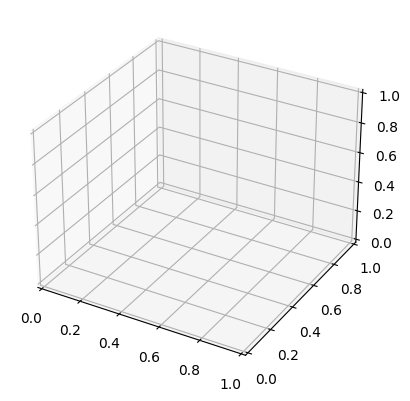

In [20]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 打开ROOT文件
file = uproot.open("/data/event/final/sg_10ppwax/Events/run_01/tag_1_delphes_events.root")

# 获取树对象
tree = file["Delphes;1"]

# 读取 Jet.Constituents 和 Jet.Particles 数据
jet_constituents = tree["Jet.Constituents"].array()
jet_particles = tree["Jet.Particles"].array()

# 读取 Particle 数据
particle_pid = tree["Particle.PID"].array()
particle_pt = tree["Particle.PT"].array()
particle_eta = tree["Particle.Eta"].array()
particle_phi = tree["Particle.Phi"].array()

# 获取第一个事件中所有喷注相关粒子的详细信息
jet_particle_indices = jet_particles[0]  # 获取索引列表

# 提取第一个事件中所有喷注相关粒子的 \eta, \phi 和 p_T
etas = []
phis = []
pts = []

for indices in jet_particle_indices:
    for index in indices:
        etas.append(particle_eta[index])
        phis.append(particle_phi[index])
        pts.append(particle_pt[index])

# 将数据转换为 NumPy 数组
etas = np.array(etas)
phis = np.array(phis)
pts = np.array(pts)

# 绘制三维散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(etas, phis, pts, c=pts, cmap='viridis')
ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_zlabel('PT')

plt.colorbar(sc, label='PT')
plt.title('Jet Particles in Event 0')
plt.show()
